<a href="https://colab.research.google.com/github/ArturoMaiani/-Local-Minimization-of-Motor-Torques-on-Robots-with-Elastic-Joints-using-Null-Space-methods/blob/main/Stable_baselines_PPO_cortile_pixies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stable Baselines Tutorial - Getting Started

Github repo: https://github.com/araffin/rl-tutorial-jnrr19

Stable-Baselines: https://github.com/hill-a/stable-baselines

Documentation: https://stable-baselines.readthedocs.io/en/master/

RL Baselines zoo: https://github.com/araffin/rl-baselines-zoo

Medium article: [https://medium.com/@araffin/stable-baselines-a-fork-of-openai-baselines-df87c4b2fc82](https://medium.com/@araffin/stable-baselines-a-fork-of-openai-baselines-df87c4b2fc82)

[RL Baselines Zoo](https://github.com/araffin/rl-baselines-zoo) is a collection of pre-trained Reinforcement Learning agents using Stable-Baselines.

It also provides basic scripts for training, evaluating agents, tuning hyperparameters and recording videos.


## Introduction

In this notebook, you will learn the basics for using stable baselines library: how to create a RL model, train it and evaluate it. Because all algorithms share the same interface, we will see how simple it is to switch from one algorithm to another.


## Install Dependencies and Stable Baselines Using Pip

List of full dependencies can be found in the [README](https://github.com/hill-a/stable-baselines).

```
sudo apt-get update && sudo apt-get install cmake libopenmpi-dev zlib1g-dev
```


```
pip install stable-baselines[mpi]
```

In [1]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines[mpi]==2.10.2

TensorFlow 1.x selected.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
freeglut3-dev set to manually installed.
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 784 kB in 0s (2,927 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...

In [2]:
import stable_baselines
stable_baselines.__version__

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


'2.10.2'

## Imports

Stable-Baselines works on environments that follow the [gym interface](https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html).
You can find a list of available environment [here](https://gym.openai.com/envs/#classic_control).

It is also recommended to check the [source code](https://github.com/openai/gym) to learn more about the observation and action space of each env, as gym does not have a proper documentation.
Not all algorithms can work with all action spaces, you can find more in this [recap table](https://stable-baselines.readthedocs.io/en/master/guide/algos.html)

In [2]:
import gym
import numpy as np
from gym import Env
from gym.spaces import Discrete, Box
import random
import matplotlib.pyplot as plt
from matplotlib import colors
import time

The first thing you need to import is the RL model, check the documentation to know what you can use on which problem

In [3]:
from stable_baselines import PPO2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


The next thing you need to import is the policy class that will be used to create the networks (for the policy/value functions).
This step is optional as you can directly use strings in the constructor: 

```PPO2('MlpPolicy', env)``` instead of ```PPO2(MlpPolicy, env)```

Note that some algorithms like `SAC` have their own `MlpPolicy` (different from `stable_baselines.common.policies.MlPolicy`), that's why using string for the policy is the recommened option.

In [4]:
from stable_baselines.common.policies import MlpPolicy

## Create the Gym env and instantiate the agent

For this example, we will use CartPole environment, a classic control problem.

"A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. "

Cartpole environment: [https://gym.openai.com/envs/CartPole-v1/](https://gym.openai.com/envs/CartPole-v1/)

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)

Note: vectorized environments allow to easily multiprocess training. In this example, we are using only one process, hence the DummyVecEnv.

We chose the MlpPolicy because input of CartPole is a feature vector, not images.

The type of action to use (discrete/continuous) will be automatically deduced from the environment action space


Here we are using the [Proximal Policy Optimization](https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html) algorithm (PPO2 is the version optimized for GPU), which is an Actor-Critic method: it uses a value function to improve the policy gradient descent (by reducing the variance).

It combines ideas from [A2C](https://stable-baselines.readthedocs.io/en/master/modules/a2c.html) (having multiple workers and using an entropy bonus for exploration) and [TRPO](https://stable-baselines.readthedocs.io/en/master/modules/trpo.html) (it uses a trust region to improve stability and avoid catastrophic drops in performance).

PPO is an on-policy algorithm, which means that the trajectories used to update the networks must be collected using the latest policy.
It is usually less sample efficient than off-policy alorithms like [DQN](https://stable-baselines.readthedocs.io/en/master/modules/dqn.html), [SAC](https://stable-baselines.readthedocs.io/en/master/modules/sac.html) or [TD3](https://stable-baselines.readthedocs.io/en/master/modules/td3.html), but is much faster regarding wall-clock time.


## environment


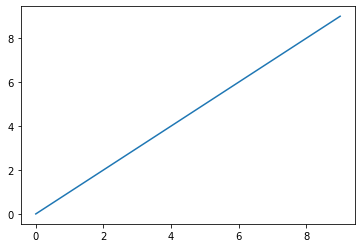

In [5]:
a=[1,2,3,4,5,6,7,8,9,0,0,1,2,2,0,0]

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

moving_average(a,4)
fig, ax = plt.subplots()
ax.plot(range(10))
plt.show()

In [21]:
a=np.array([[1,2,3],[4,0,6]])
np.transpose(np.argwhere(a>2))

array([[0, 1, 1],
       [2, 0, 2]])

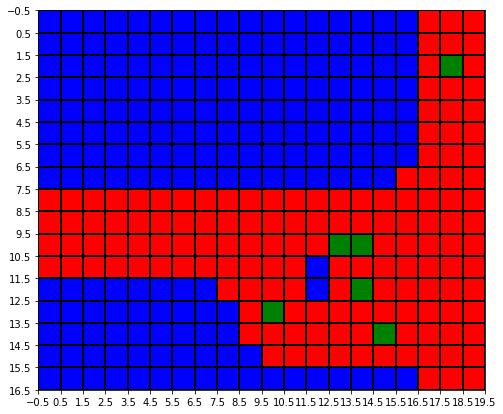

In [52]:
import copy
gain=0.5
penalty=0
size_x=17
size_y=20
mosse_max=1000
delta_t=0.7
flag_robot_su_griglia=-1
v_mid=0.4
omega_max=0.6
numero_mosse_massime=[0]
numero_partite_vinte=[0]
reward_listone=[]
lista_aree=[]

def init_reward_grid():
    grid=np.ones((17,20))*(-2)
    #print(a)
    somma=0
    for i in range(17):
        for j in range(20):
            if i>7 and i<12:
                grid[i,j]=0
            if j>16:
                grid[i,j]=0
            if i>11 and i<16 and j>9:
                grid[i,j]=0
            if i==7 and j==16:
                grid[i,j]=0
            if i==12 and j==8:
                grid[i,j]=0
            if i>11 and i<15 and j==9:
                grid[i,j]=0
    grid[8,1:3]=np.clip(np.random.uniform(-0.2,0.6,2),0,0.6)
    
    
    grid[13,10]=np.random.uniform(0.3,0.6)
    
    
    grid[14,15]=np.random.uniform(0.3,0.6)
    
    
    grid[2,18]=np.random.uniform(0.3,0.6)
    
    
    ind_1=np.random.randint(0,2)
    ind_2=np.random.randint(0,2)
    ind_3=np.random.randint(0,2)
    ind_4=np.random.randint(0,2)
    grid[10+ind_1,13+ind_2]=np.random.uniform(0.3,0.6)
    grid[10+ind_3,13+ind_4]=np.random.uniform(0.3,0.6)
    
    grid[10,14]=np.random.uniform(0.3,0.6)
    
    
    grid[12,14]=np.random.uniform(0.3,0.6)
    grid[11:13,12]=np.ones(2)*(-2)
    
    grigliona_pixel=copy.copy(grid)#NON SI SMETTE MAI DI IMPARARE

    for i in range(17):
        for j in range(20):
            if grigliona_pixel[i,j]>0:
                somma+=grigliona_pixel[i,j]
                grigliona_pixel[i,j]=1
    
    return grid,somma,grigliona_pixel


#print(np.round(grid,0))
cmap = colors.ListedColormap(['blue', 'red','green','pink'])

bounds = [-2,-0.1,0.3,0.7,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
    

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(init_reward_grid()[0], cmap=cmap,norm=norm)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-0.5, 20, 1));
        
ax.set_yticks(np.arange(-0.5, 17, 1)); 





#define a function that determines if the specified location is a terminal state
def is_terminal_state(current_row_index, current_column_index):
  #if the reward for this location is -1, then it is not a terminal state (i.e., it is a 'white square')
  
  if env.reward_grid[current_row_index, current_column_index] >0 or env.reward_grid[current_row_index, current_column_index] <-0.5:
    return True
  else:
      return False


#define a function that will choose a random, non-terminal starting location
def get_starting_location():
  #get a random row and column index

  current_row_index = np.random.randint(1,size_x-2)
  current_column_index = np.random.randint(1,size_y-2)
  #continue choosing random row and column indexes until a non-terminal state is identified
  #(i.e., until the chosen state is a 'white square').
  while is_terminal_state(current_row_index, current_column_index):
    current_row_index = np.random.randint(1,size_x-2)
    current_column_index = np.random.randint(1,size_y-2)
  #print(env.reward_grid)
  #print(env.reward_grid[current_row_index, current_column_index])
  return current_row_index, current_column_index

def vectorize_map(map):
    # map è init_pixel_grid() quindi booleana, contiene 1 dove sta la monnezza, 
    # -2 dove stanno le mura, -1 dove sta il robot e il resto 0
    vector = [i for i in np.reshape(map,-1) if i>-2]
    return vector
size=len(vectorize_map(init_reward_grid()[0]))


In [ ]:
'''
def init_reward_grid_(a):
    
    grid=np.zeros((10,10))
    #print(a)
    if a==0:#funziona
        for i in range(4):
            for j in range(4):
                grid[3+i,3+j]=np.random.uniform(0.3,1)
                
    if a==1:#funziona
        grid[1,1:4]=np.random.uniform(0,1,3)
        grid[5:8,1]=np.random.uniform(0,1,3)
        grid[5:8,5]=np.random.uniform(0,1,3)
        grid[3:6,8]=np.random.uniform(0,1,3)
        grid[2:7,9]=np.random.uniform(0,1,5) 
        if size>9:
            for i in range(size-9):
                grid=np.insert(grid,i,0,0)# last input tells if row=0 or column=1, second input tells which row or column
                grid=np.insert(grid,i,0,1)
    if a==2:
        grid[1:3,1:6]=np.random.uniform(0.3,1,(2,5))
        grid[1:6,1]=np.random.uniform(0.3,1,5)
        grid[5:7,5:7]=np.random.uniform(0.3,1,(2,2))

        
        grid=grid.transpose()
    if a==3:#funziona
        grid[9,2:10]=np.random.uniform(0.3,1,8)
        grid[4:10,9]=np.random.uniform(0.3,1,6)
        grid[4:7,3:5]=np.random.uniform(0.3,1,(3,2))

        
    if a==4:
        
        for i in range(size+1):
            for j in range(size+1):
                
                if np.random.uniform(0,1)>0.85:
                    grid[i,j]=np.random.uniform(0.5,1)

        
    grid[:,0]=np.random.uniform(0,1,np.shape(grid)[0])
    grid[0,:]=np.random.uniform(0,1,np.shape(grid)[1])
    #print(np.round(grid,1))
    h=np.multiply(grid,gain)
    
    return h,np.sum(h)
########
def init_reward_grid(a):
    
    grid=np.ones((17,20))
    #print(a)

    for i in range(17):
        for j in range(20):
            if i>7 and i<12:
                grid[i,j]=0
            if j>16:
                grid[i,j]=0
            if i>11 and i<16 and j>9:
                grid[i,j]=0
            if i==7 and j==16:
                grid[i,j]=0
            if i==12 and j==8:
                grid[i,j]=0
            if i>11 and i<15 and j==9:
                grid[i,j]=0
    return grid
               
    
########




In [69]:




action_list=[
             [v_mid,-omega_max],
             [v_mid,0],
             [v_mid,omega_max]
             ]


class PiazzaDelPopolo(Env):
    

    def __init__(self):
        
        pos_x_init=0
        pos_y_init=0
        theta_in=random.uniform(0,1)

        self.reward_grid=[]
        self.pixel_grid=[]
        
        self.state=np.zeros(size+4)
       
        self.state[4:size+4] = np.zeros(size)
        self.state[0:4] = [pos_x_init/size_x,pos_y_init/size_y,theta_in,0]

        self.action_space = Discrete(len(action_list))
        highh=np.concatenate((np.array([1,1,1,1]),np.ones(size)))
        loww= np.concatenate((np.array([0,0,0,0]),-np.ones(size)))
        
            
        self.observation_space = Box(low=loww,high=highh)
        # x y theta battery %completata - pixels
        
        # l'area coperta all'inizio è zero quindi manca ancora 1
        self.stato_memoria=[]
        
        
    


    def step(self, action):
        # metto a zero l'elemento della pixel grid in cui stava prima il robot
        self.pixel_grid[int(np.round((size_x-1)*self.state[0])),int(np.round((size_y-1)*self.state[1]))]=0
        
        if random.randint(0,15000)==5:
            print('----------')
            print('partite vinte:',numero_partite_vinte[0])
            print('partite con troppe mosse:',numero_mosse_massime[0])
            print('area max ultime 100 partite:',np.max(lista_aree[len(lista_aree)-100:]))
            print('----------')
            if len(reward_listone)>10000:
                fig, ax = plt.subplots()
                ax.plot(moving_average(reward_listone,20000)[10000:])
                plt.show()
        #if self.state[4]>0.5:
        #    reward=-1*(-20*self.state[4]+21)
        #else:
        #    reward=-2
        
           #prima -0.5 era troppo
        self.stato_memoria=[self.state[0],self.state[1]]
        if self.state[0]<=1 and self.state[0]>=0 and self.state[1]<=1 and self.state[1]>=0:       
            angolone=self.state[2]*np.pi*2
            self.state[0]+=delta_t*np.cos(angolone)*action_list[action][0]/(size_x-1)
            self.state[1]+=delta_t*np.sin(angolone)*action_list[action][0]/(size_y-1)
            self.state[2]+=delta_t*action_list[action][1]/(2*np.pi)
            
        if self.state[2]>1:
            self.state[2]-=1
        if self.state[2]<0:
            self.state[2]+=1
            

        if self.state[0]>=1:
            done=True
            reward=-1
            lista_aree.append(self.state[3])
            self.state[0]=1
            info = {}
            reward_listone.append(reward)
            return self.state, reward, done, info
            
        if self.state[0]<=0:
            done=True
            reward=-1
            lista_aree.append(self.state[3])
            self.state[0]=0
            info = {}
            reward_listone.append(reward)
            return self.state, reward, done, info
            
        if self.state[1]>=1:
            done=True
            reward=-1
            lista_aree.append(self.state[3])
            self.state[1]=1
            info = {}
            reward_listone.append(reward)
            return self.state, reward, done, info
            
        if self.state[1]<=0:
            done=True
            reward=-1
            lista_aree.append(self.state[3])
            self.state[1]=0
            info = {}
            reward_listone.append(reward)
            return self.state, reward, done, info

        if self.reward_grid[int(np.round((size_x-1)*self.state[0])),int(np.round((size_y-1)*self.state[1]))]==-2:
            done=True
            reward=-1
            lista_aree.append(self.state[3])
            self.state[0:2]=self.stato_memoria
            info = {}
            reward_listone.append(reward)
            return self.state, reward, done, info
       
            

        # battery decrease
        
        
        

        self.mossa+=1
        pos_x=int(np.round(self.state[0]*(size_x-1)))
        pos_y=int(np.round(self.state[1]*(size_y-1)))

        
        

        # prende il valore della casella : 
        
        reward=self.reward_grid[pos_x,pos_y]
        
        # metto a 3 l'elemento della pixel grid in cui sta attualmente il robot
        self.pixel_grid[pos_x,pos_y]=flag_robot_su_griglia

#-------Garbage collected----------------------------------------        
        if reward>0:
            #print('preso',reward)
            #remove garbage from square
            self.reward_grid[pos_x,pos_y]=penalty
            self.state[3]+=reward/self.somma
        
        # AGGIORNO LO STATO!!!!!! MI ERO DIMENTICATO
        self.state[4:size+4] = vectorize_map(self.pixel_grid)
         #define a function that determines if the specified location is a terminal state
        if self.state[3]>0.6:# il 3 è l'AREA COPERTA!!!!
            reward=1
            lista_aree.append(self.state[3])
            numero_partite_vinte[0]+=1
            done=True
        elif self.mossa >mosse_max:
            lista_aree.append(self.state[3])
            numero_mosse_massime[0]+=1
            done=True
        else:
            done= False
        

        info = {}
        reward_listone.append(reward)
        # Return step information
        return self.state, reward, done, info

    def render(self):
        pass
    
    
    
    def reset(self):
        self.state=np.zeros(size+4)
        
       
        #print(a)
        theta_in=random.uniform(0,1)

        self.GRIGLIA_INIZIALE=init_reward_grid()

        self.reward_grid=self.GRIGLIA_INIZIALE[0]
        
        
        
        self.somma=self.GRIGLIA_INIZIALE[1]
        #print('somma',self.somma)
        self.pixel_grid=self.GRIGLIA_INIZIALE[2]
        
        pos_x_reset,pos_y_reset=get_starting_location() #this is integer
        #pos_x_reset,pos_y_reset=[11,16]
        self.pixel_grid[pos_x_reset,pos_y_reset]=flag_robot_su_griglia
        
        self.state[0:4] = [pos_x_reset/(size_x-1),pos_y_reset/(size_y-1),theta_in,0]
        self.state[4:size+4] = vectorize_map(self.pixel_grid)
        
     
        self.mossa=0
        
        
        return self.state

# FONDAMENTALE PER CREARE L ENVIRONMENT
env=PiazzaDelPopolo()

def plottagrid(matrice):
    
    px=env.state[0]*(size_x-1)
    py=env.state[1]*(size_y-1)
    cmap = colors.ListedColormap(['blue', 'red','green','pink'])
    bounds = [-2,-0.1,0.1,0.3,0.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    theta=env.state[2]*2*np.pi
    lungo=1

    fig, ax = plt.subplots(figsize=(8, 8))
   
    ax.imshow(matrice, cmap=cmap,norm=norm)
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-0.5, 20, 1));
        
    ax.set_yticks(np.arange(-0.5, 17, 1)); 
 
    plt.plot([py,py+lungo*np.sin(theta)],[px,px+lungo*np.cos(theta)],linewidth=5,color='white')
    plt.plot(py, px, marker="o", markersize=20, markeredgecolor="white", markerfacecolor="white")
 
    
#print(np.round(grid,0))




    






/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [17]:
len(env.state)

152

somma 3.6861025161149077
mossa numero 1
posizione [12.841625556745239, 13.964620561808143, 0.8377219055338058, 0.0] reward 0.0 azione [0.4, -0.6]
------------------------------------------------------------------
mossa numero 2
posizione [13.04069990102829, 14.183645594217438, 1.2577219055338056, 0.0] reward 0.0 azione [0.4, 0.6]
------------------------------------------------------------------
preso 0.43067744313936157
mossa numero 3
posizione [13.132325457773529, 14.46405562970979, 1.6777219055338055, 0.11683816205776301] reward 0.43067744313936157 azione [0.4, 0.6]
------------------------------------------------------------------
mossa numero 4
posizione [13.100575678518553, 14.757109201621796, 1.6777219055338055, 0.11683816205776301] reward 0.0 azione [0.4, 0]
------------------------------------------------------------------
mossa numero 5
posizione [13.068825899263576, 15.050162773533803, 2.097721905533805, 0.11683816205776301] reward 0.0 azione [0.4, 0.6]
---------------------

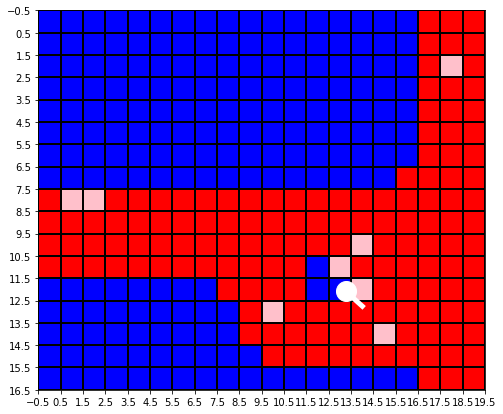

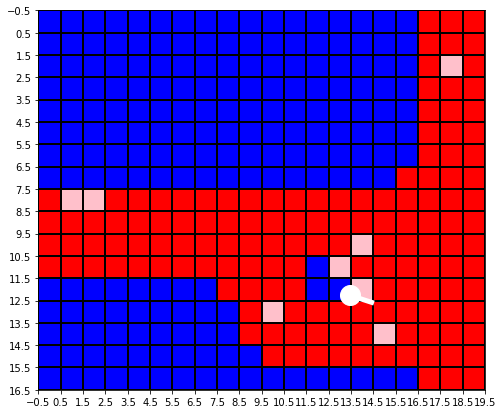

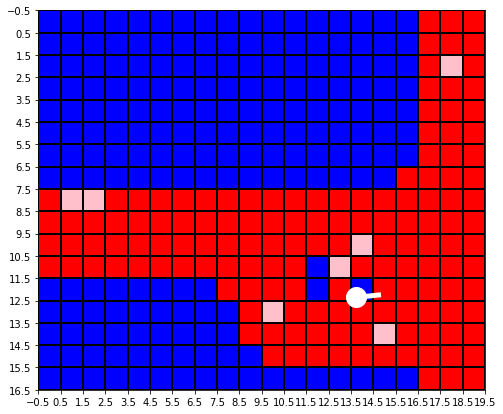

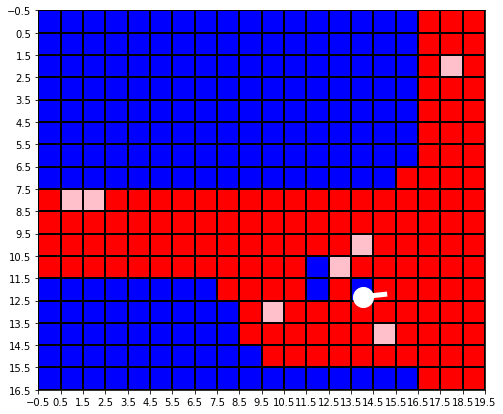

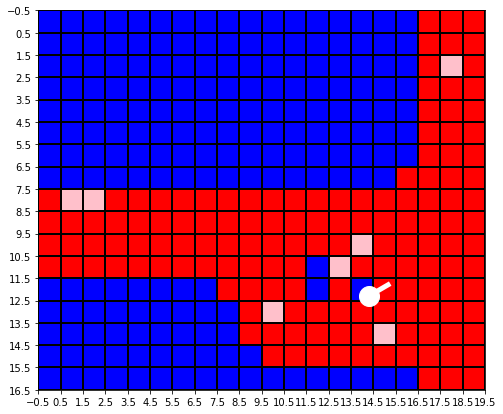

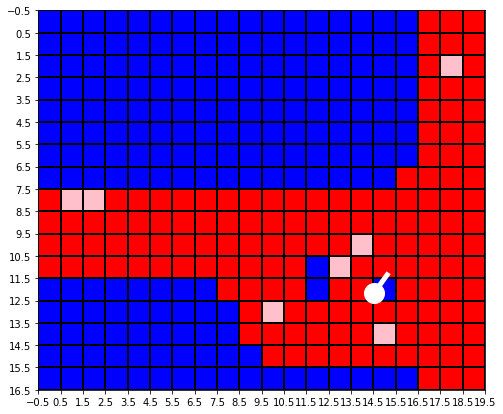

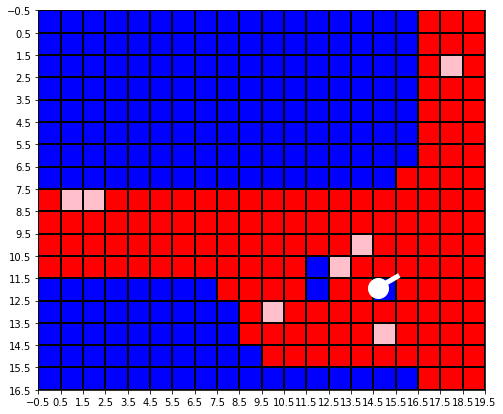

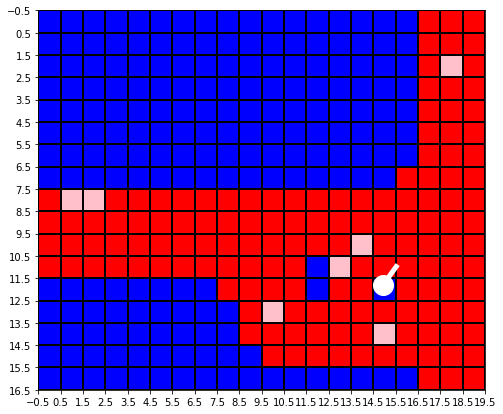

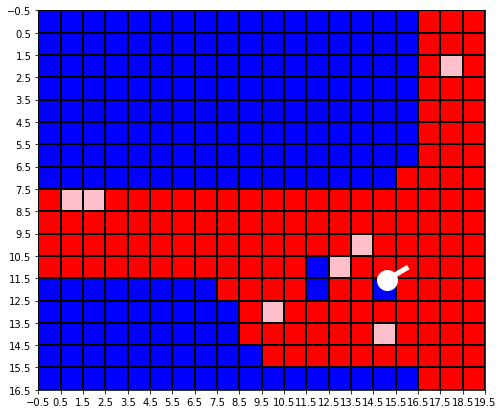

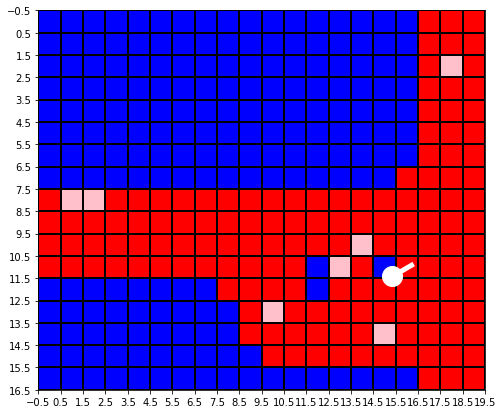

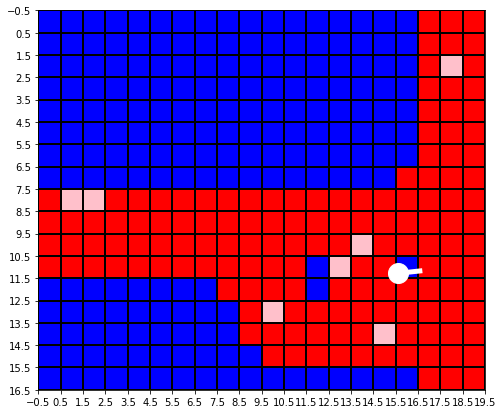

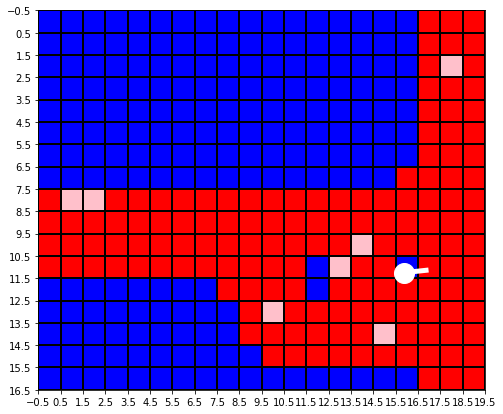

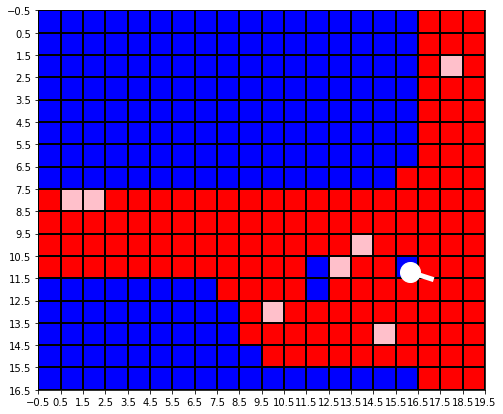

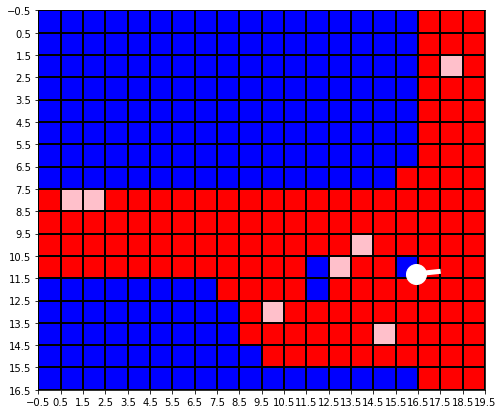

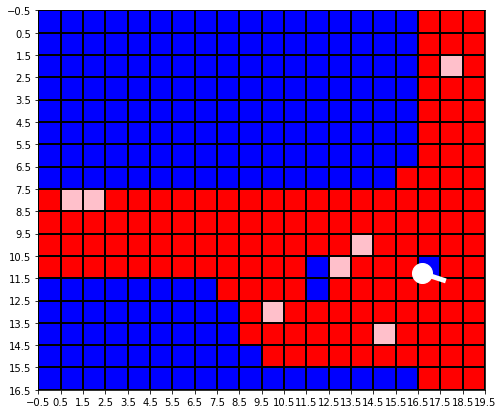

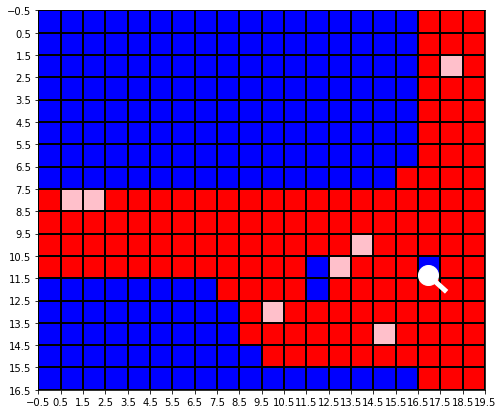

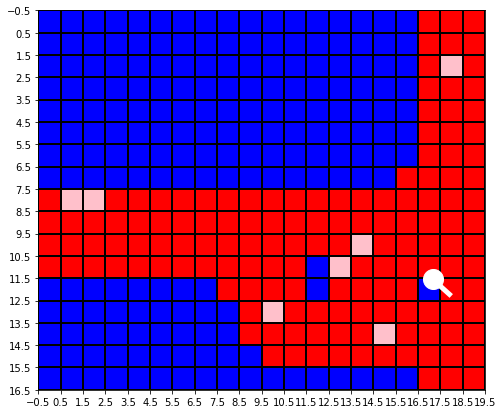

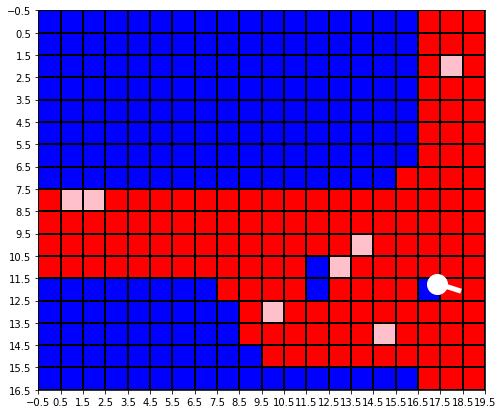

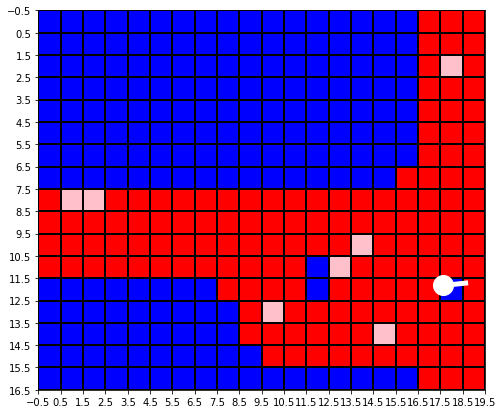

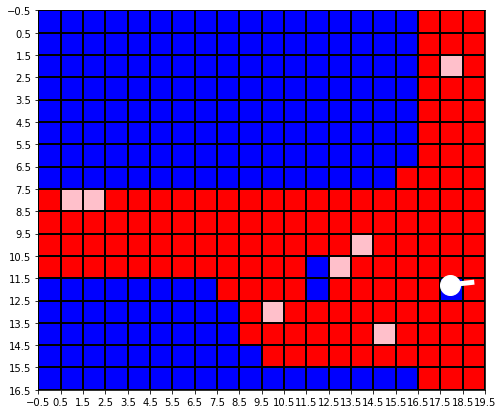

In [62]:
episodes = 1
for episode in range(1, episodes+1):
    env.reset()
    #print(np.multiply(env.reset()[0:2],size))
    #print(env.reward_grid)
    #print('batteria',env.state[3])
    done = False
    score = 0 
    
    #while not done:
    for i in range(20):
        #env.render()
        #temp=[env.state[0],env.state[1]]
        action = env.action_space.sample()
        #action = 0
        n_state, reward, done, info = env.step(action)
        #print(np.round(env.reward_grid,2))
        score+=reward
        #print(np.round(env.pixel_grid,1))
        plottagrid(env.pixel_grid.reshape(size_x,size_y))
        #drawnow()
        print('mossa numero',env.mossa)
        print('posizione',[env.state[0]*size_x,env.state[1]*size_y,env.state[2]*np.pi*2,env.state[3]],'reward',reward,'azione',action_list[action])
        
        print('------------------------------------------------------------------')
       

In [70]:
#env = gym.make('CartPole-v1')
# vectorized environments allow to easily multiprocess training
# we demonstrate its usefulness in the next examples
# env = DummyVecEnv([lambda: env])
import tensorflow as tf
policy_kwargs = dict(act_fun=tf.nn.tanh, net_arch=[80, 80])
model = PPO2(MlpPolicy, env,policy_kwargs=policy_kwargs, verbose=0)
'''
policy, env, gamma=0.99, n_steps=128, ent_coef=0.01,
learning_rate=0.00025, vf_coef=0.5, max_grad_norm=0.5,
lam=0.95, nminibatches=4, noptepochs=4,
cliprange=0.2, cliprange_vf=None, verbose=0, tensorboard_log=None, _init_setup_model=True, policy_kwargs=None, full_tensorboard_log=False, seed=None,
n_cpu_tf_sess=None'''


'\npolicy, env, gamma=0.99, n_steps=128, ent_coef=0.01,\nlearning_rate=0.00025, vf_coef=0.5, max_grad_norm=0.5,\nlam=0.95, nminibatches=4, noptepochs=4,\ncliprange=0.2, cliprange_vf=None, verbose=0, tensorboard_log=None, _init_setup_model=True, policy_kwargs=None, full_tensorboard_log=False, seed=None,\nn_cpu_tf_sess=None'

We create a helper function to evaluate the agent:

In [18]:
def evaluate(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

In fact, Stable-Baselines already provides you with that helper:

In [19]:
from stable_baselines.common.evaluation import evaluate_policy

Let's evaluate the un-trained agent, this should be a random agent.

In [71]:
# Use a separate environement for evaluation
#eval_env = gym.make('CartPole-v1')
eval_env = env
# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=3)


print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-0.03 +/- 0.69


## Train the agent and evaluate it

----------
partite vinte: 1
partite con troppe mosse: 2
area max ultime 100 partite: 0.674394194357992
----------


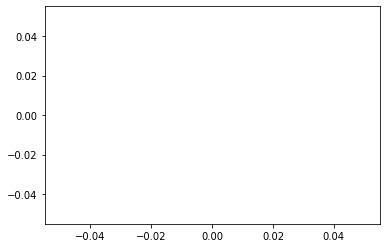

----------
partite vinte: 2
partite con troppe mosse: 26
area max ultime 100 partite: 0.5367712503415725
----------


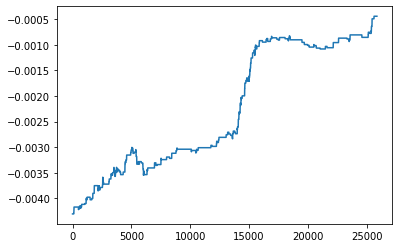

----------
partite vinte: 2
partite con troppe mosse: 32
area max ultime 100 partite: 0.5367712503415725
----------


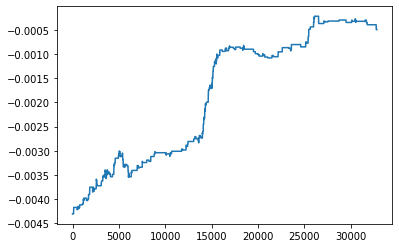

----------
partite vinte: 2
partite con troppe mosse: 33
area max ultime 100 partite: 0.5267662537617601
----------


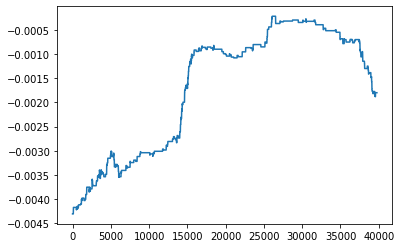

----------
partite vinte: 2
partite con troppe mosse: 33
area max ultime 100 partite: 0.5267662537617601
----------


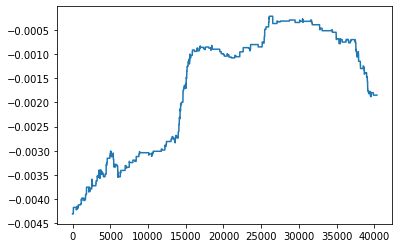

----------
partite vinte: 2
partite con troppe mosse: 33
area max ultime 100 partite: 0.5267662537617601
----------


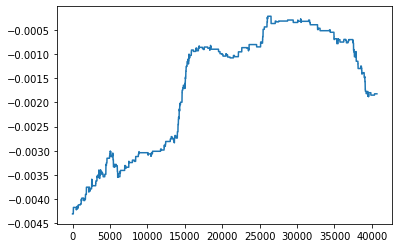

----------
partite vinte: 3
partite con troppe mosse: 34
area max ultime 100 partite: 0.47351938471977933
----------


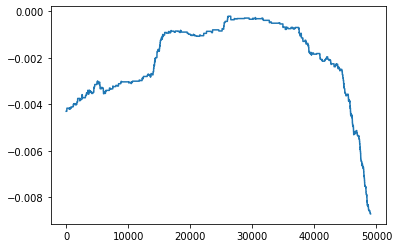

----------
partite vinte: 4
partite con troppe mosse: 49
area max ultime 100 partite: 0.5837722478869264
----------


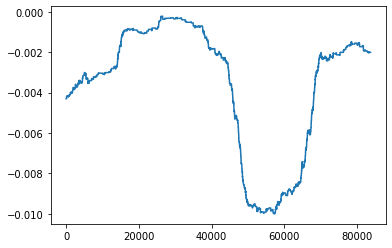

----------
partite vinte: 4
partite con troppe mosse: 54
area max ultime 100 partite: 0.5837722478869264
----------


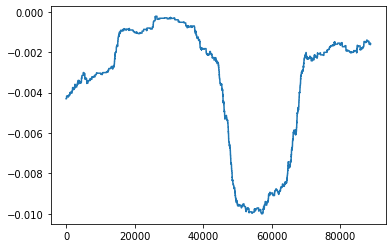

----------
partite vinte: 5
partite con troppe mosse: 65
area max ultime 100 partite: 0.6220177695393685
----------


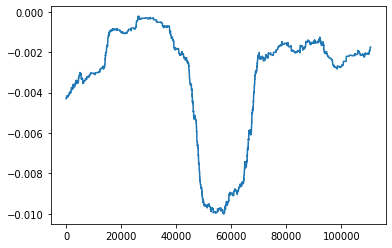

----------
partite vinte: 5
partite con troppe mosse: 70
area max ultime 100 partite: 0.6220177695393685
----------


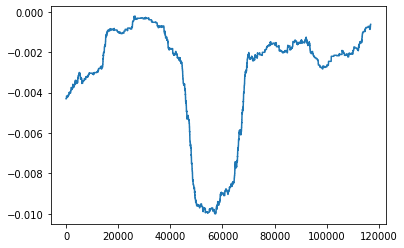

----------
partite vinte: 5
partite con troppe mosse: 82
area max ultime 100 partite: 0.6220177695393685
----------


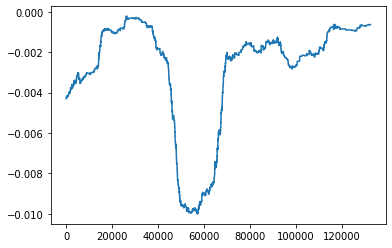

----------
partite vinte: 5
partite con troppe mosse: 86
area max ultime 100 partite: 0.6220177695393685
----------


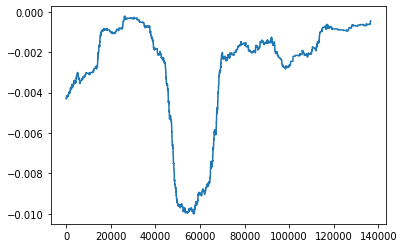

In [ ]:
# Train the agent for 10000 steps
#400'000 steps in 12 minutes
model.learn(total_timesteps=1000000)
# Evaluate the trained agent

'''
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=50)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

fig, ax = plt.subplots()
ax.plot(moving_average(reward_listone,20000))


from google.colab import files
plt.savefig("PPO_.png")
files.download("PPO_.png")


model.save("PPO_")
files.download("PPO_.zip")

episodes = 1
for episode in range(1, episodes+1):
    obs = env.reset()
    print('------------')
    done = False
    score = 0 
    for i in range(120):
        if done==True:
            break
        action, _states = model.predict(obs)
        obs, reward, dones, info = env.step(action)
        
        score+=reward
        plottagrid(env.reward_grid.reshape(size+1,size+1))
        #time.sleep(0.4)
        #print('mossa numero',env.mossa,'AREA COPERTA',env.state[3],'stato batteria',env.state[4])
        #print('posizione',np.round(env.state[0:3],2),'reward',reward,'azione',action_list[action])
'''

In [ ]:
lista_aree[len(lista_aree)-100:]
#len(lista_aree)-100

In [ ]:
#mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

from google.colab import files
plt.savefig("PPO_.png")
files.download("PPO_.png")


model.save("PPO_")
files.download("PPO_.zip")

------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:217: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


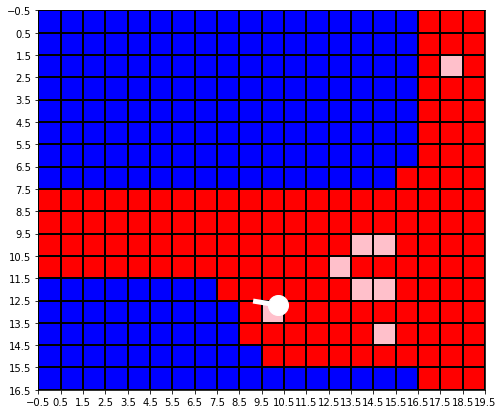

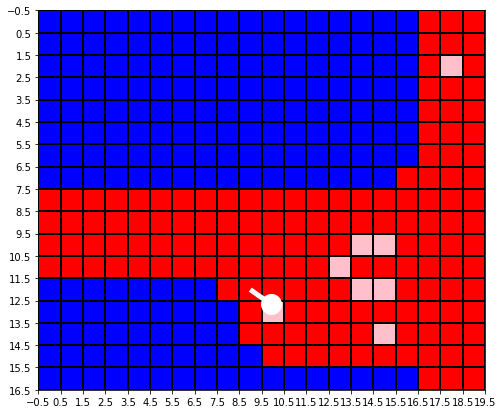

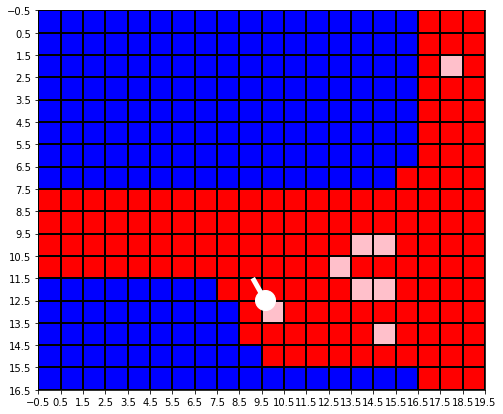

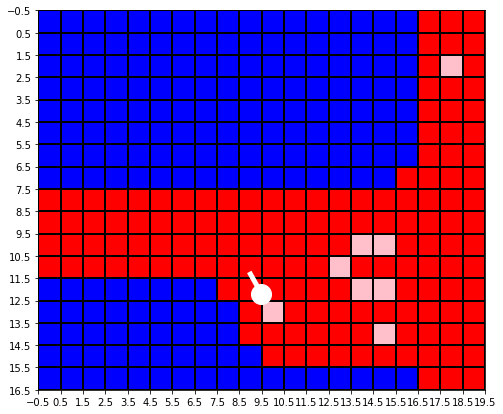

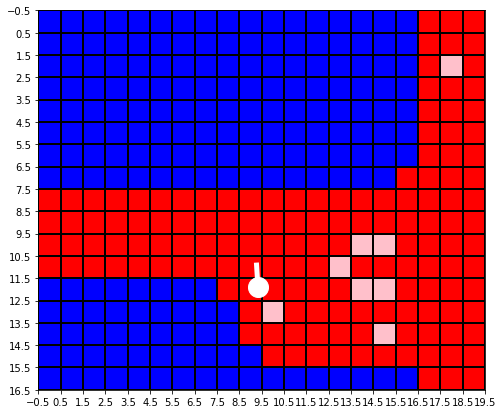

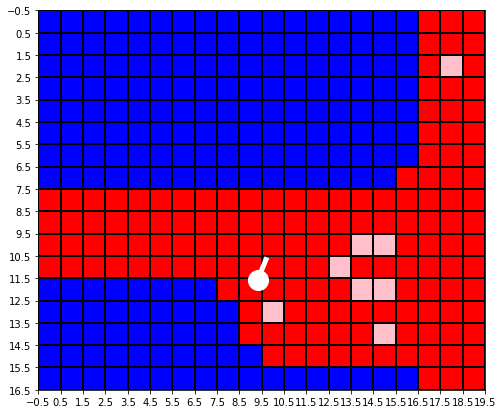

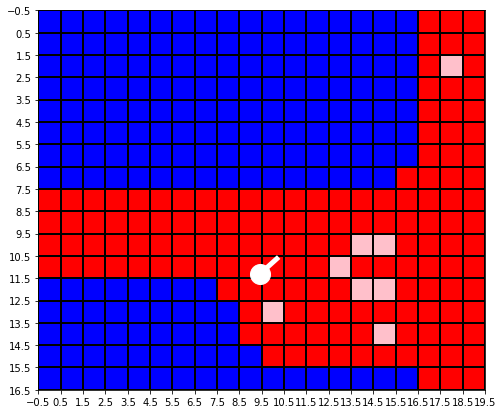

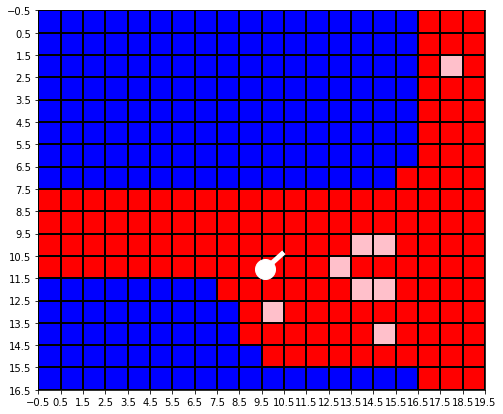

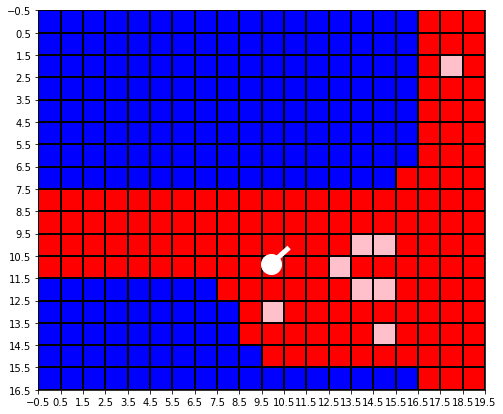

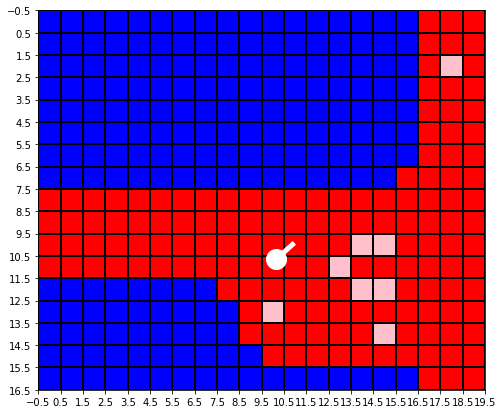

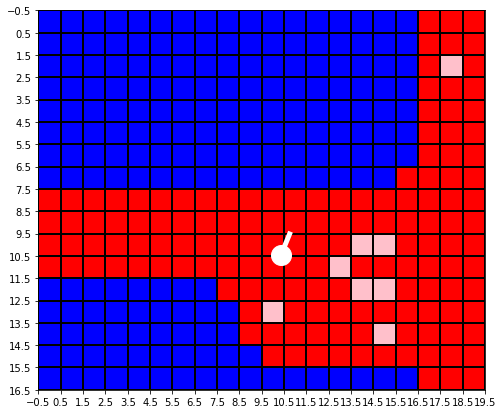

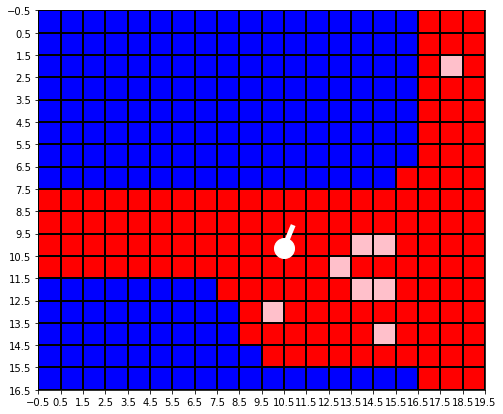

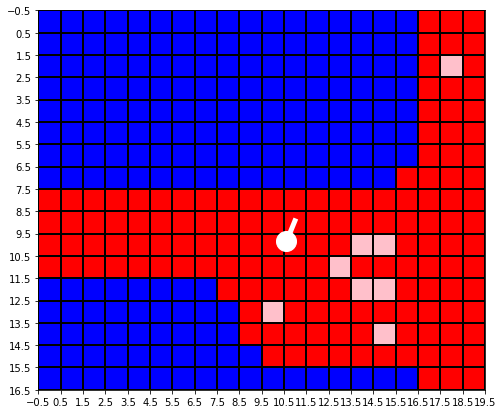

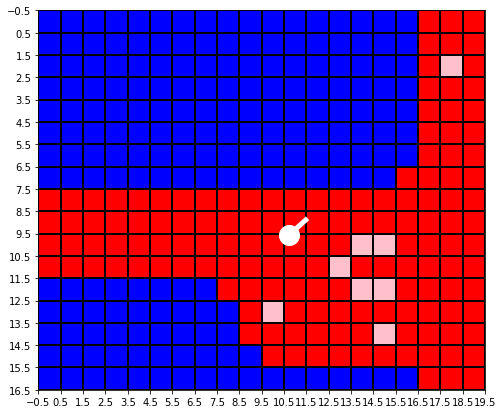

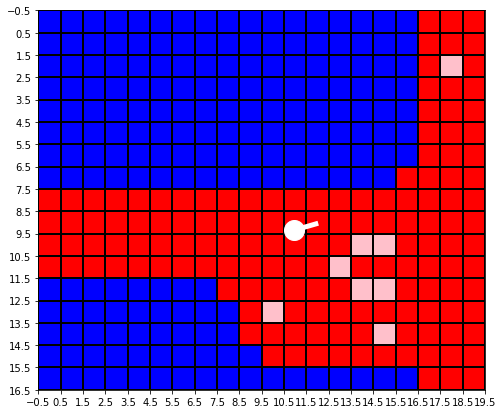

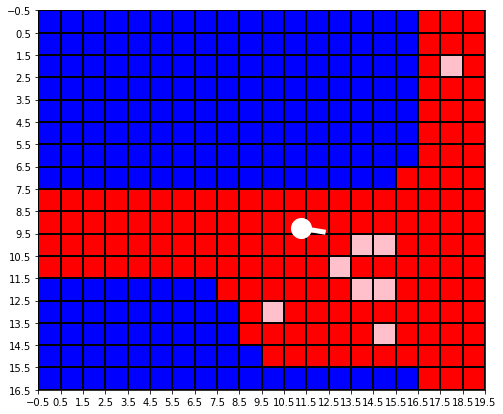

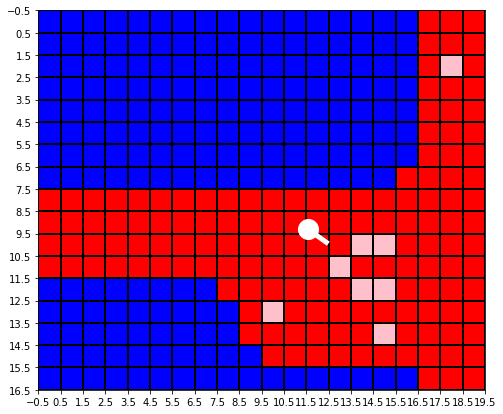

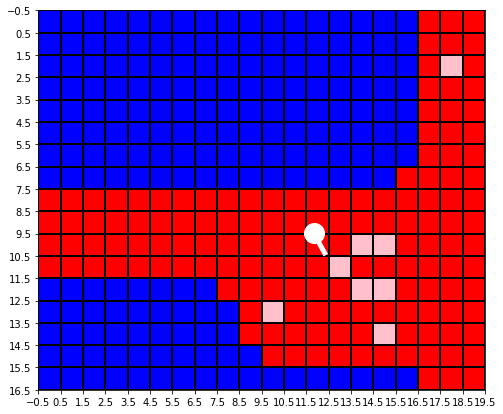

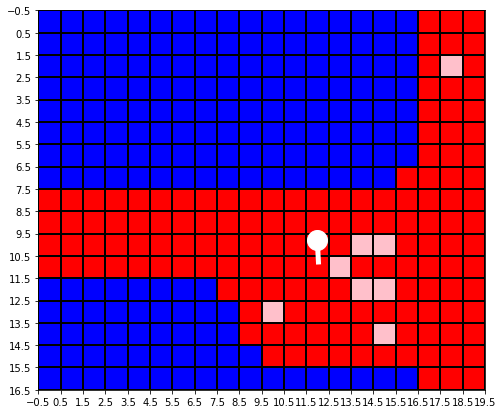

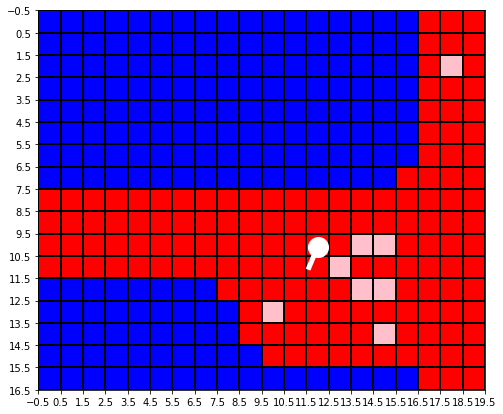

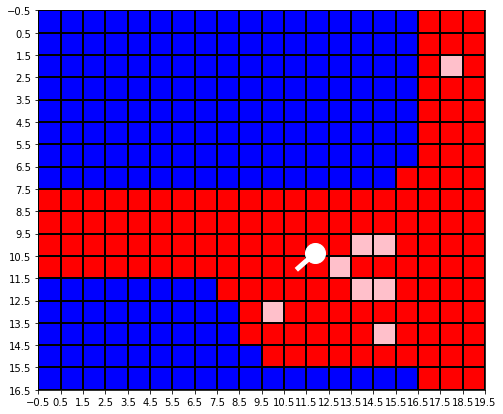

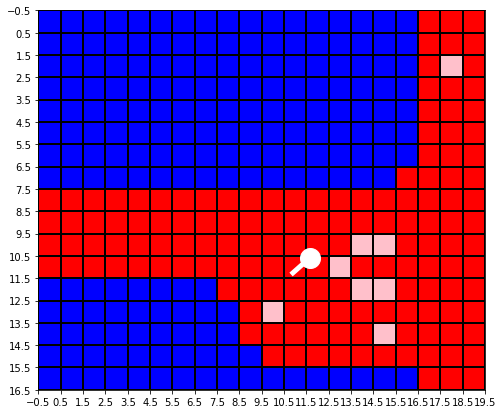

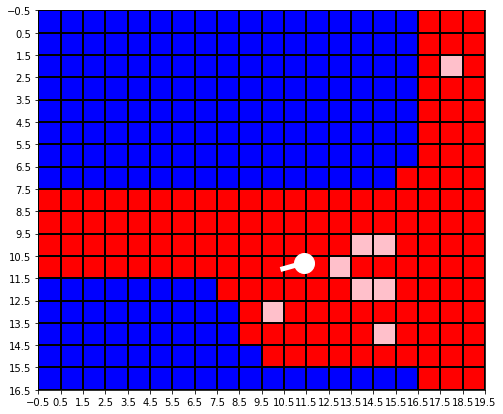

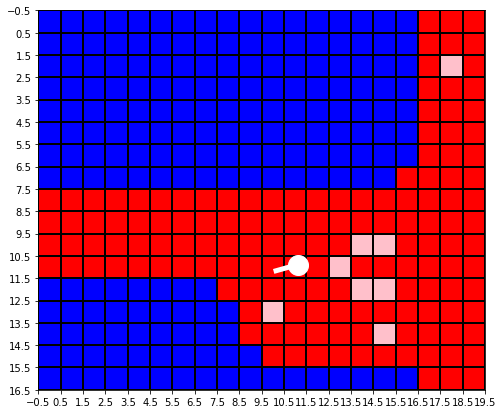

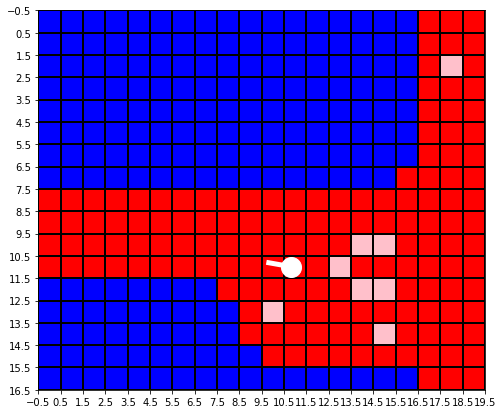

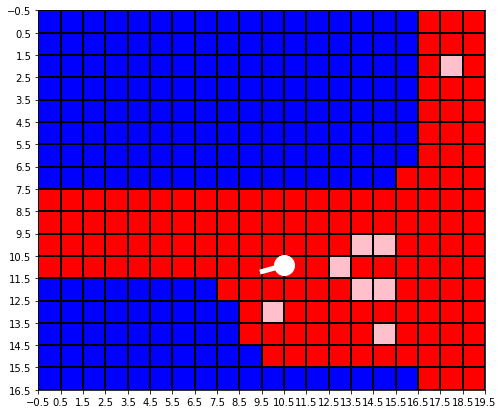

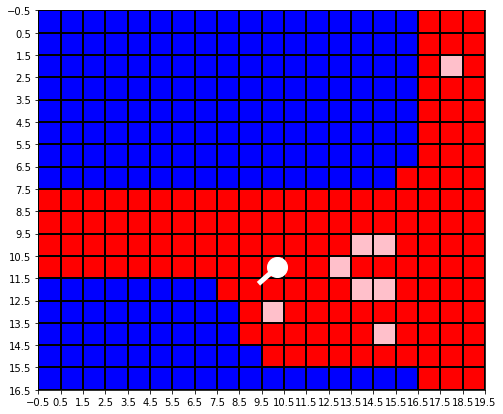

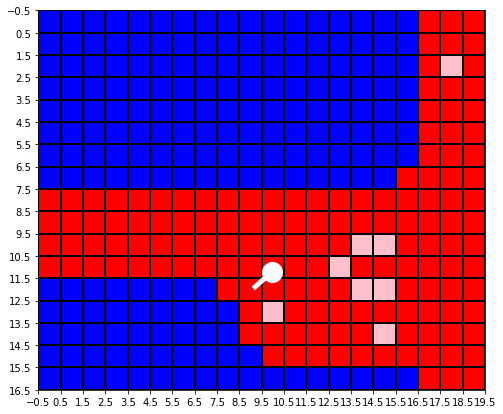

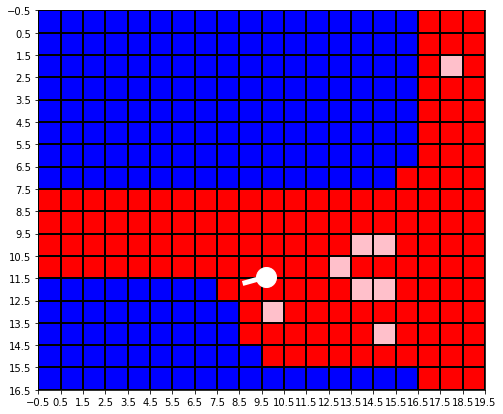

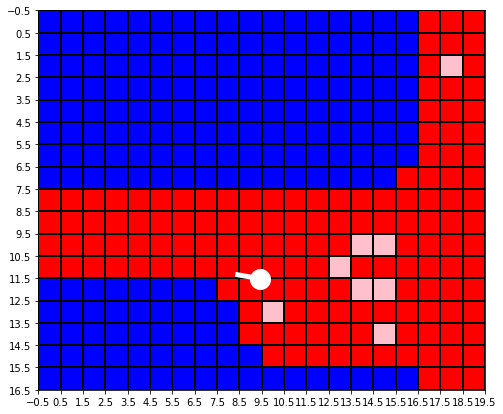

In [163]:


episodes = 1
for episode in range(1, episodes+1):
    obs = env.reset()
    print('------------')
    done = False
    score = 0 
    for i in range(30):
        if done==True:
            break
        action, _states = model.predict(obs)
        obs, reward, dones, info = env.step(action)
        
        score+=reward
        plottagrid(env.reward_grid.reshape(size_x,size_y))
        #time.sleep(0.4)
        #print('mossa numero',env.mossa,'AREA COPERTA',env.state[3],'stato batteria',env.state[4])
        #print('posizione',np.round(env.state[0:3],2),'reward',reward,'azione',action_list[action])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

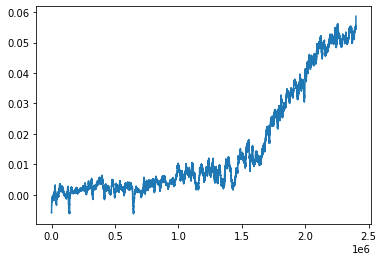

In [ ]:
#risultato con mappa  3 rete da 32,32
# ho provato per 2*10^6 passi 
from google.colab import files
fig, ax = plt.subplots()
ax.plot(moving_average(reward_listone,10000))
plt.savefig("PPO_primo_tentativo_10^6_steps_mappa3.png")
files.download("PPO_primo_tentativo_10^6_steps_mappa3.png")
plt.show()

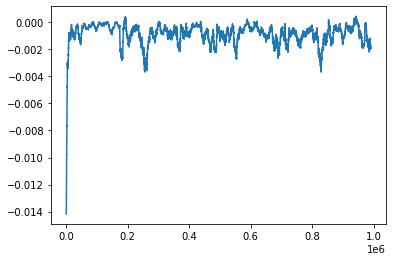

In [ ]:
#risultato con mappe 0 1 2 3 rete da 32,32
# ho provato per 10^6 passi con 4 mappe che appariavano randomicamente e il risultato è stato questo
fig, ax = plt.subplots()
ax.plot(moving_average(reward_listone,10000))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

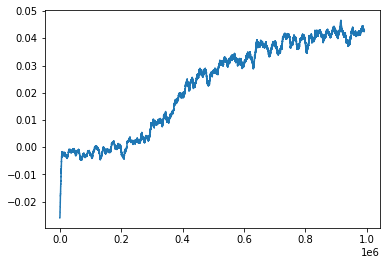

In [ ]:
#risultato con mappa 0 rete default da 32,32
fig, ax = plt.subplots()
ax.plot(moving_average(reward_listone,10000))

from google.colab import files
plt.savefig("PPO_primo_tentativo_10^6_steps.png")
files.download("PPO_primo_tentativo_10^6_steps.png")
plt.show()
#bisogna mettere il metodo plt.show() dopo aver messo il savefig 
#altrimenti salva un immagine bianca vuota

In [ ]:
model.save("PPO_primo_tentativo_10^6_passi_mappa_3")

Apparently the training went well, the mean reward increased a lot ! 

------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:295: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


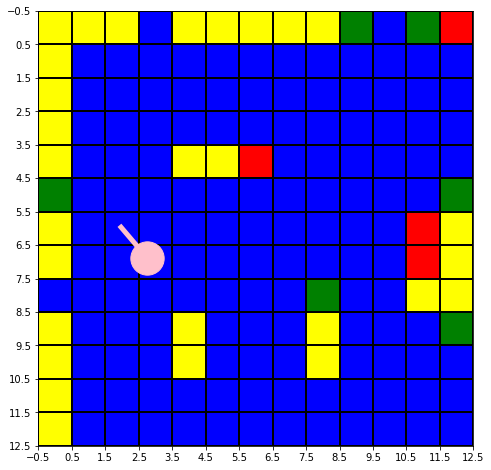

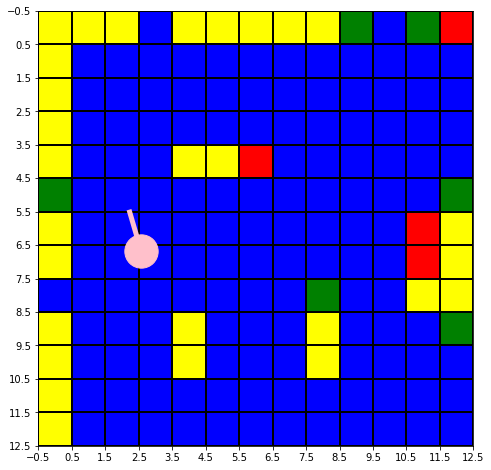

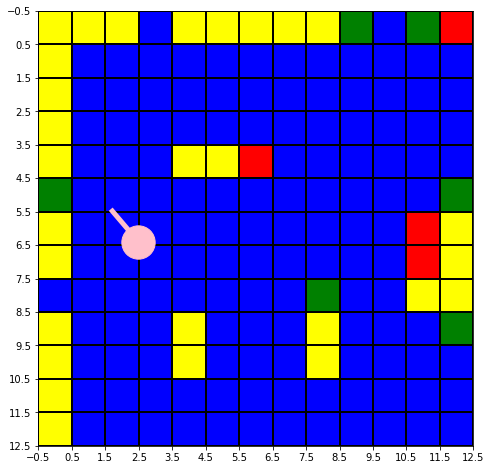

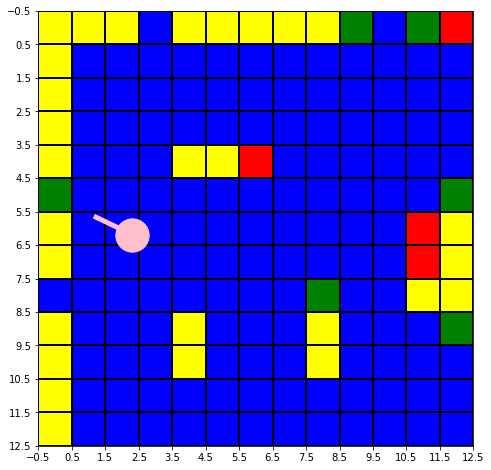

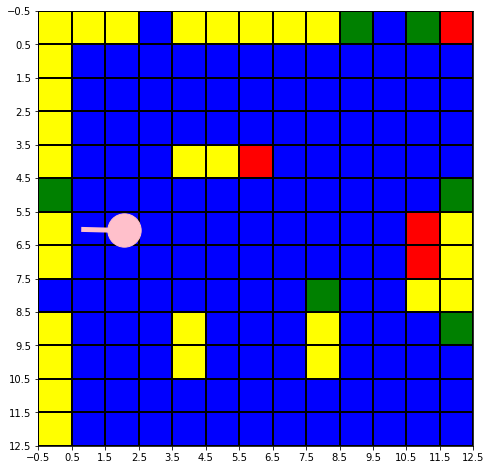

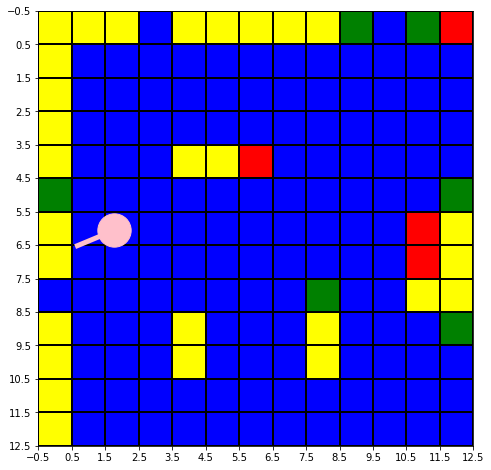

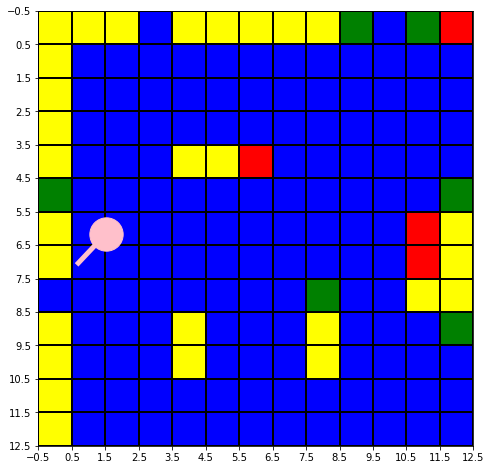

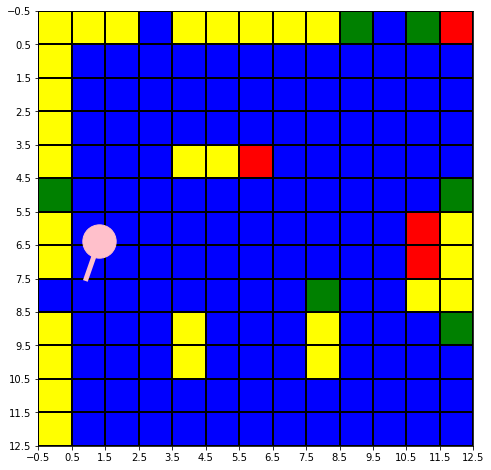

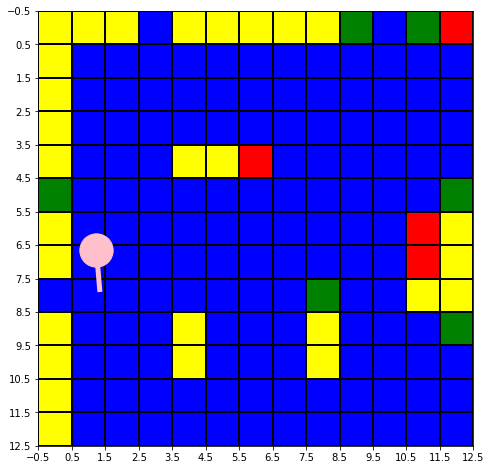

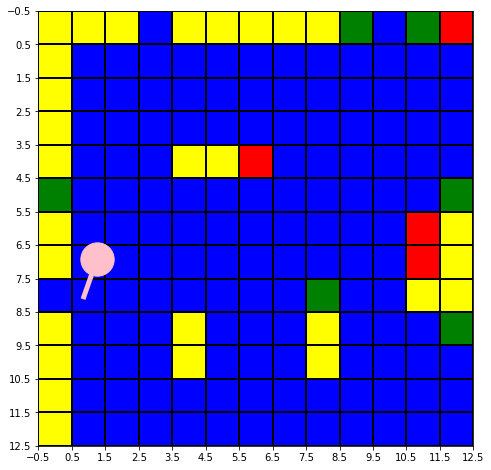

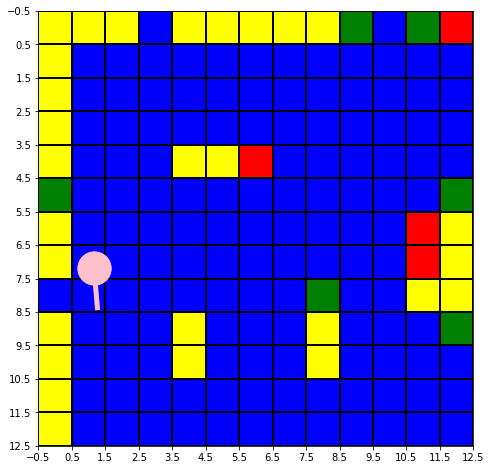

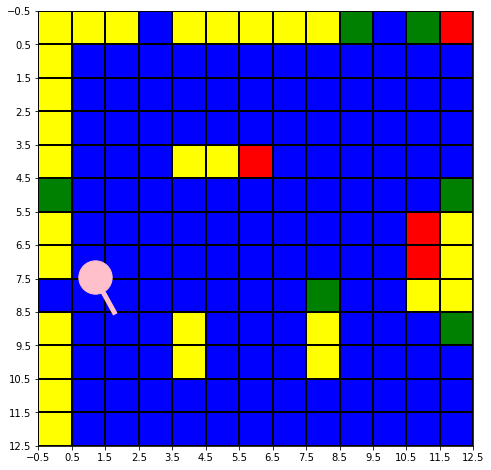

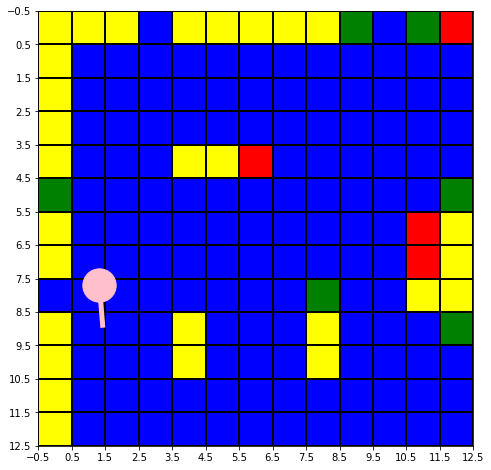

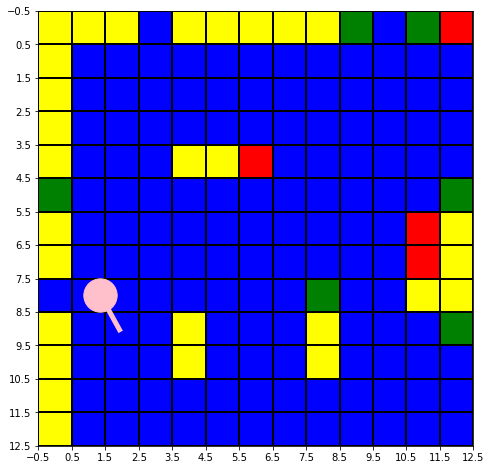

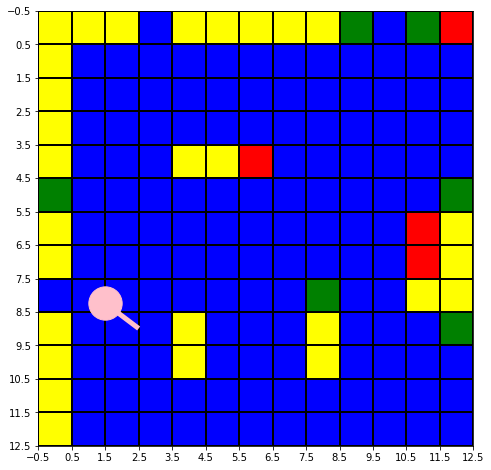

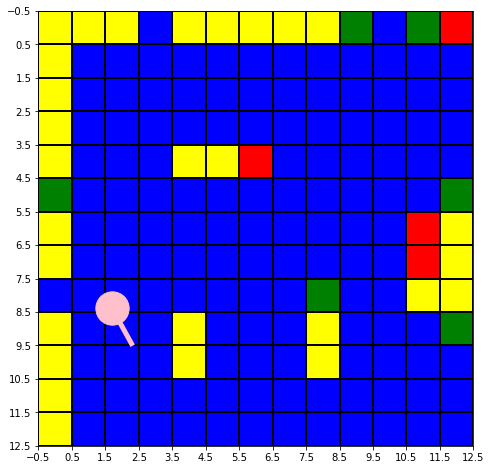

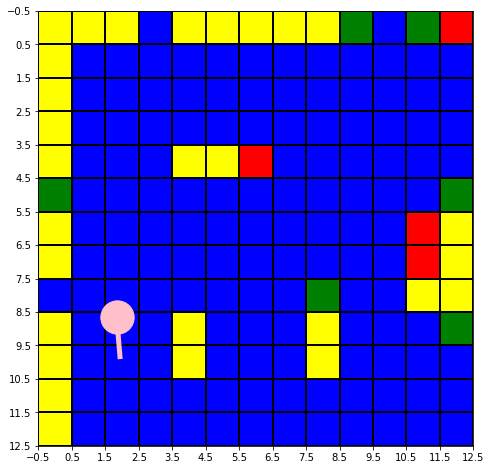

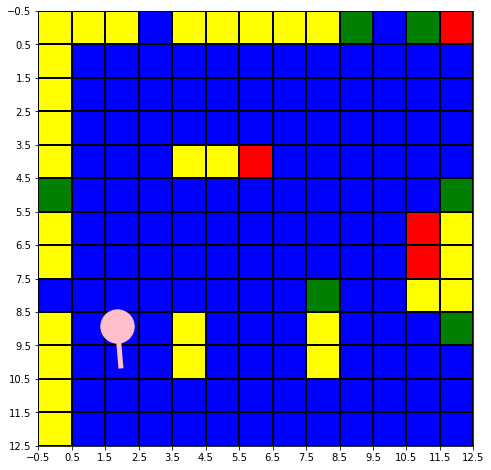

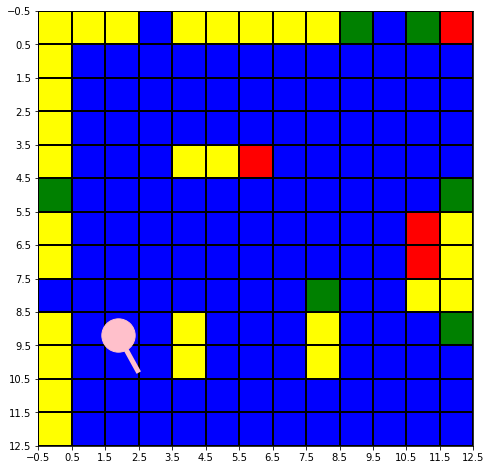

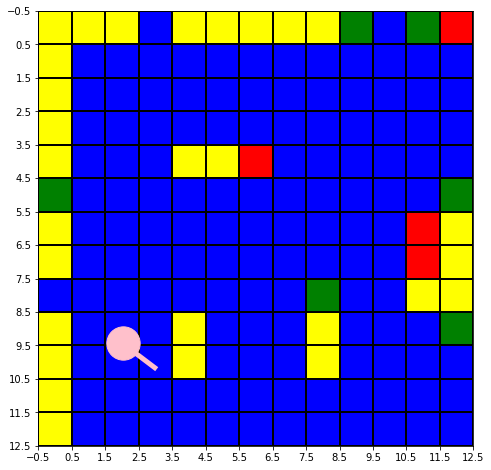

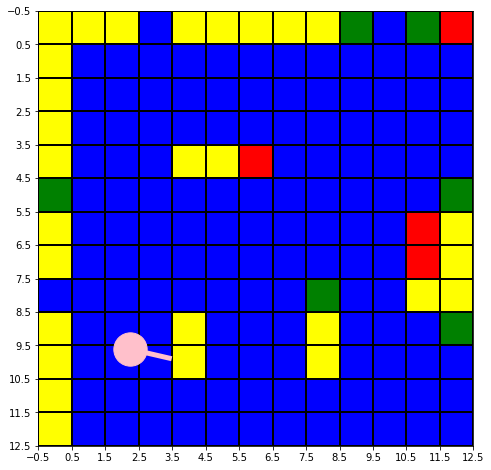

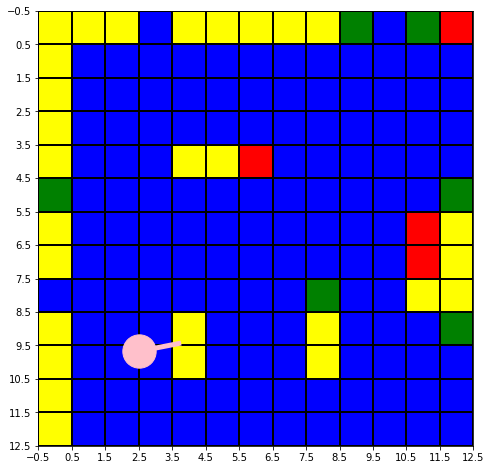

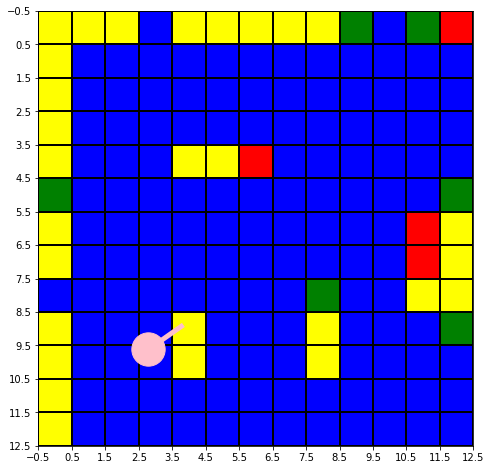

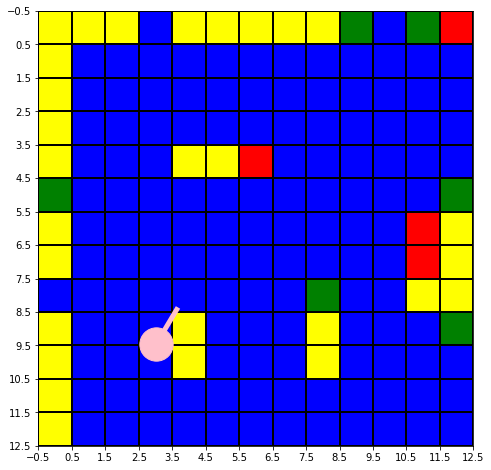

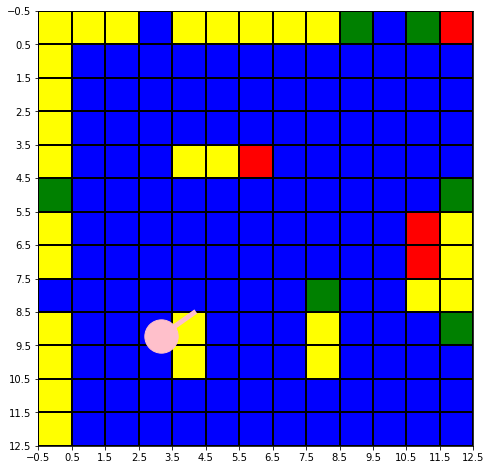

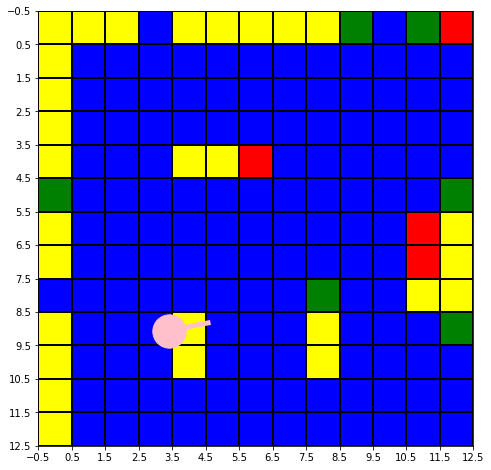

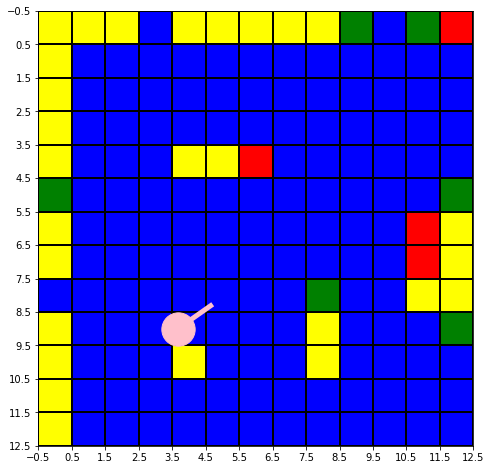

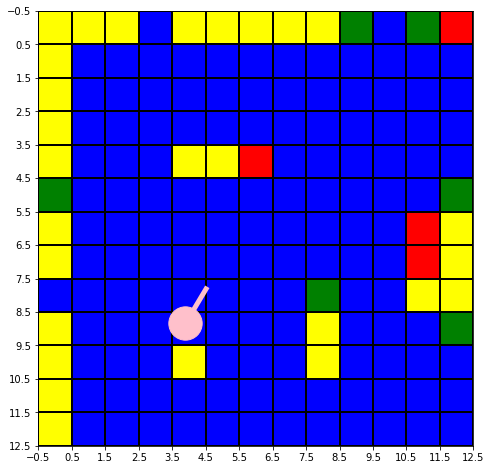

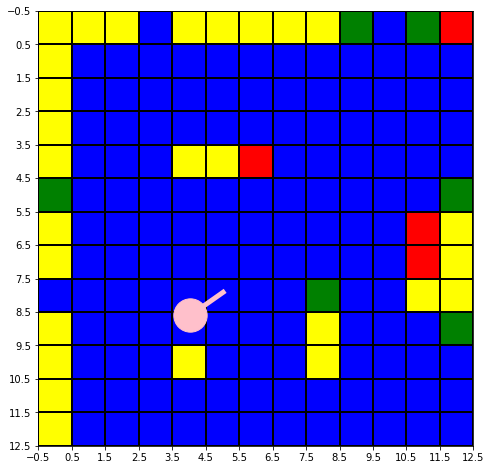

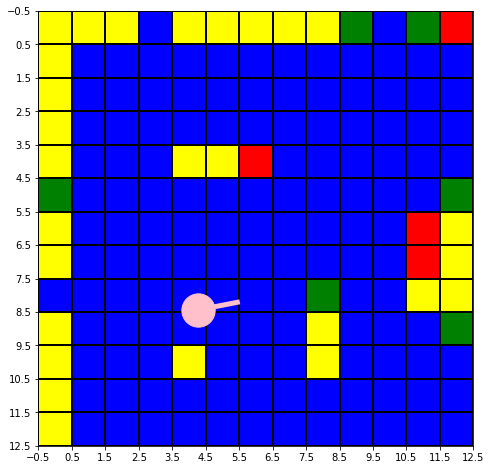

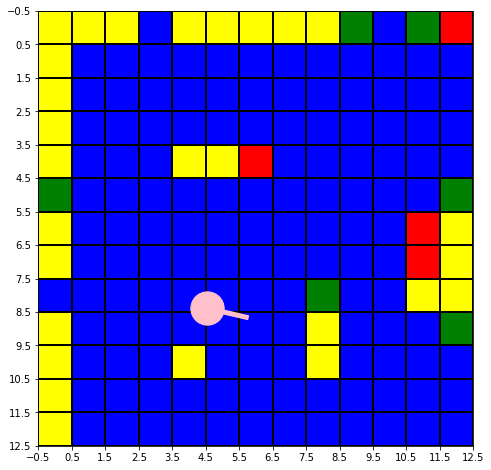

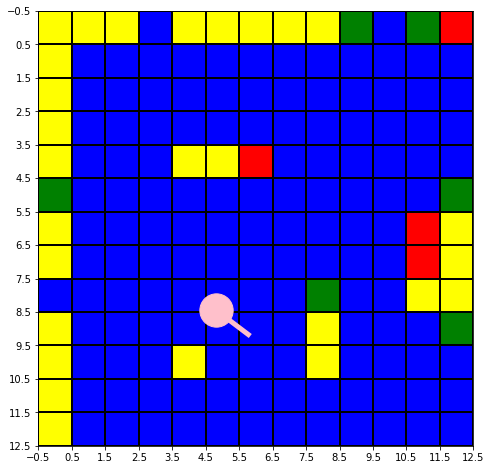

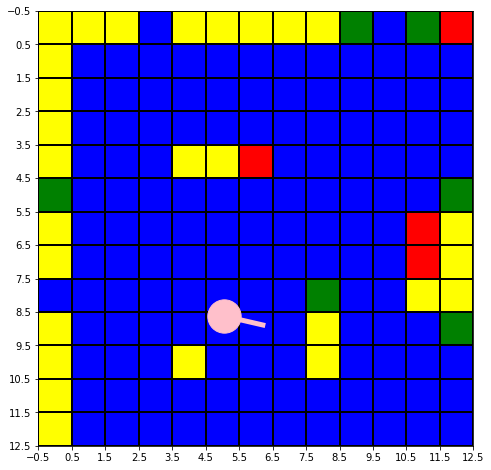

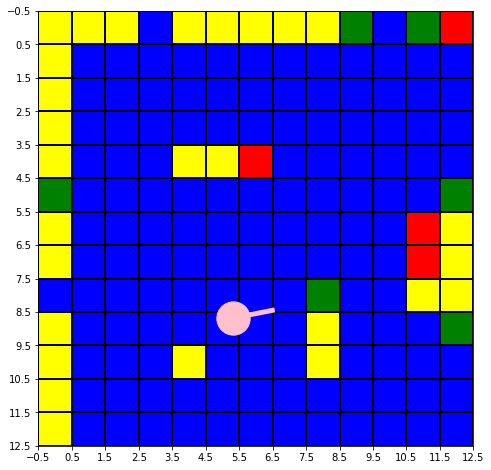

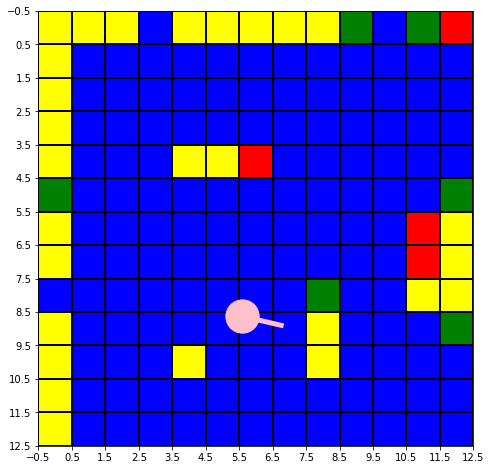

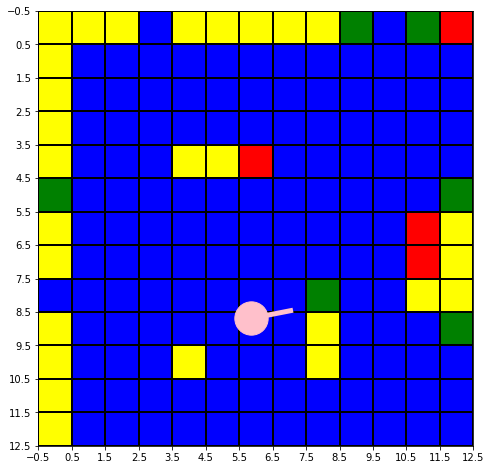

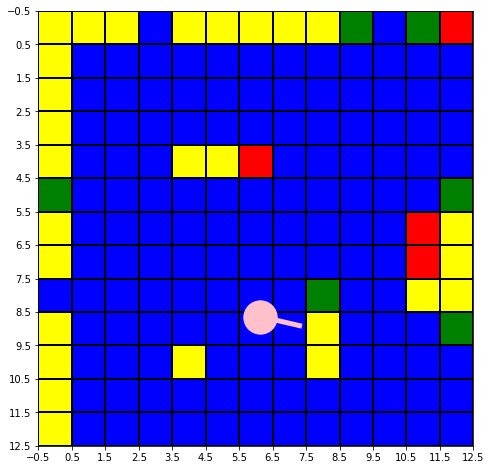

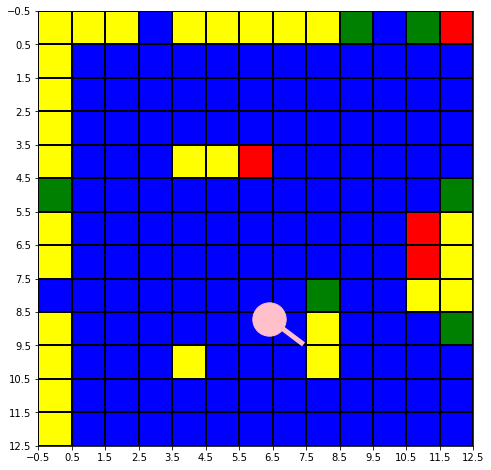

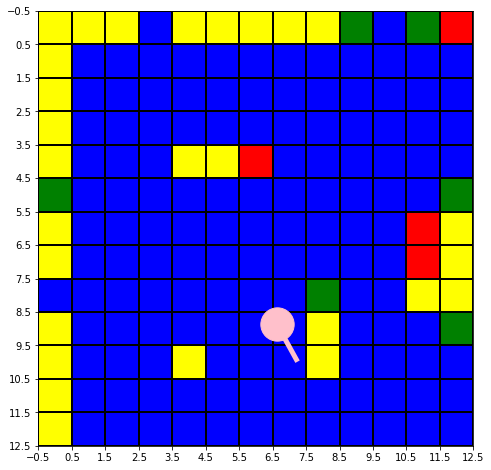

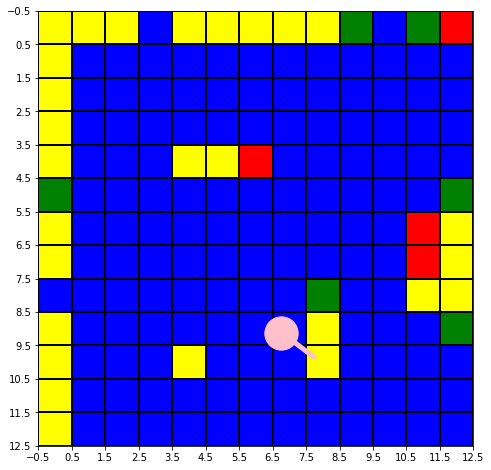

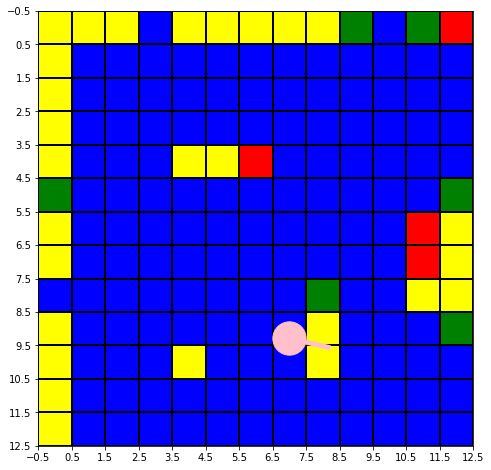

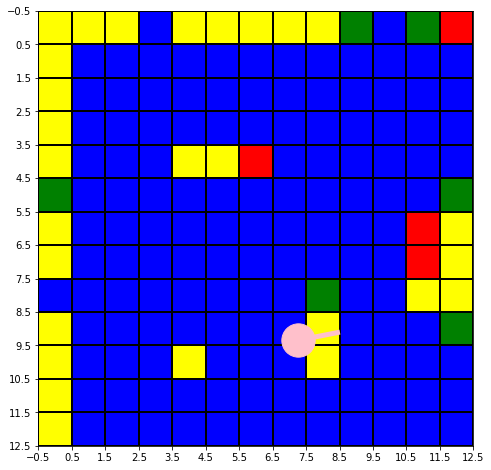

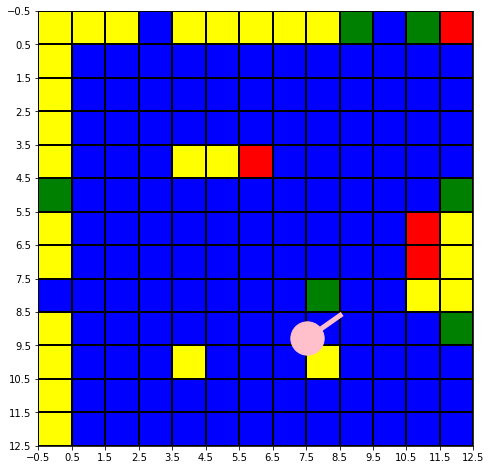

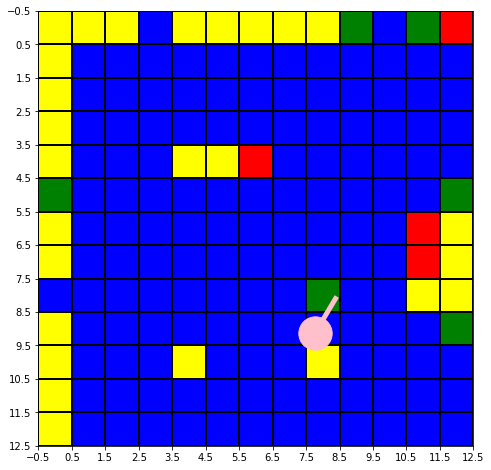

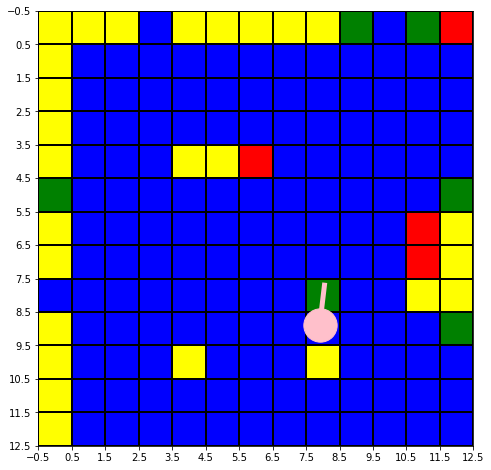

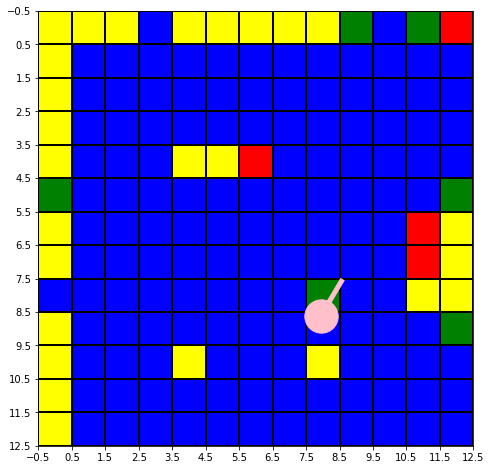

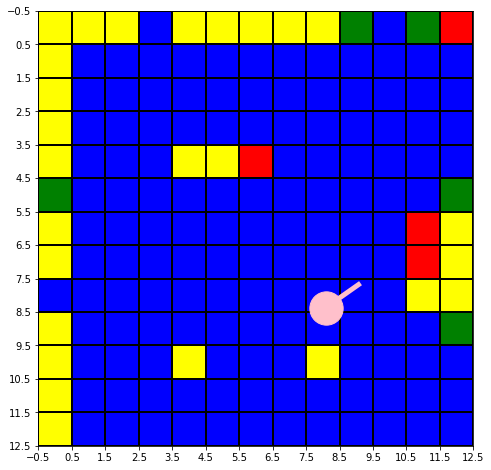

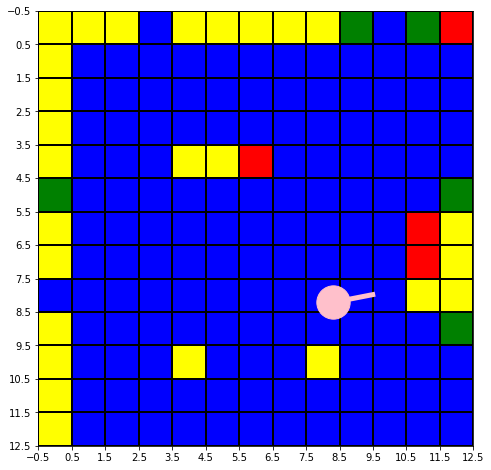

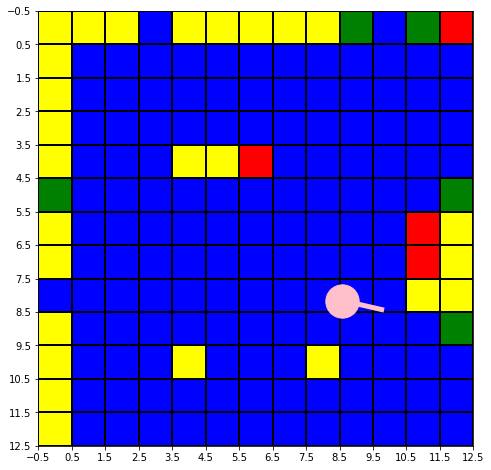

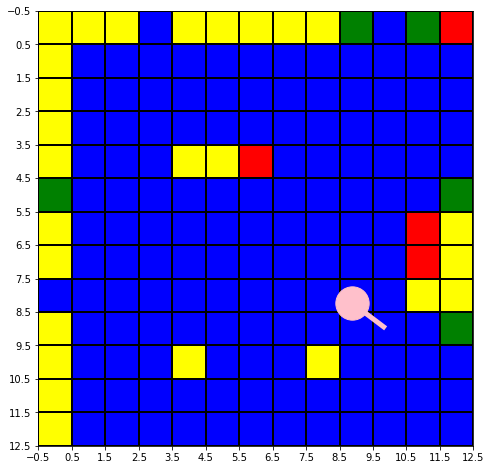

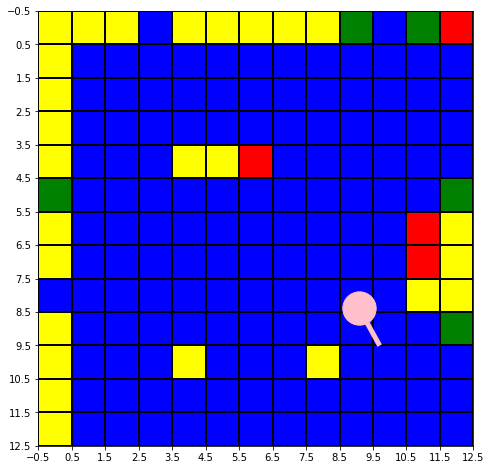

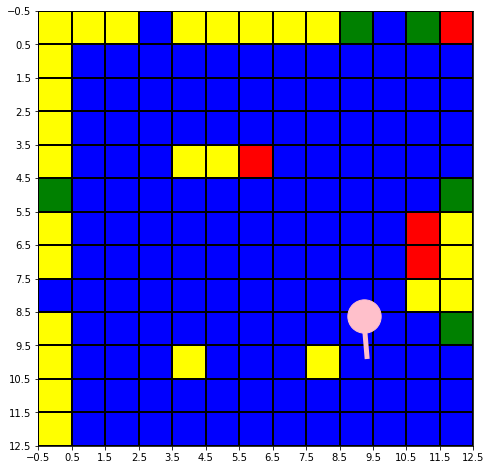

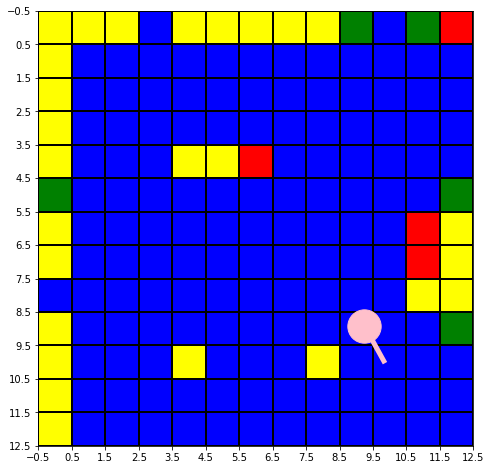

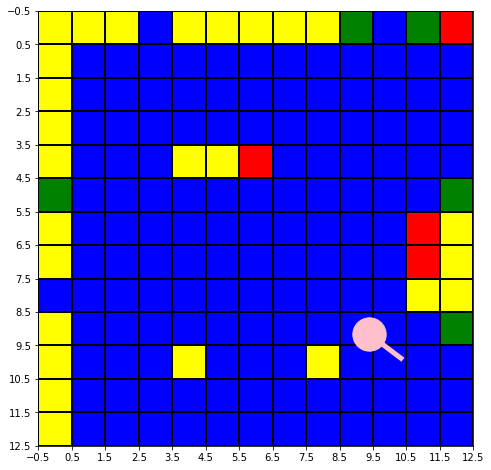

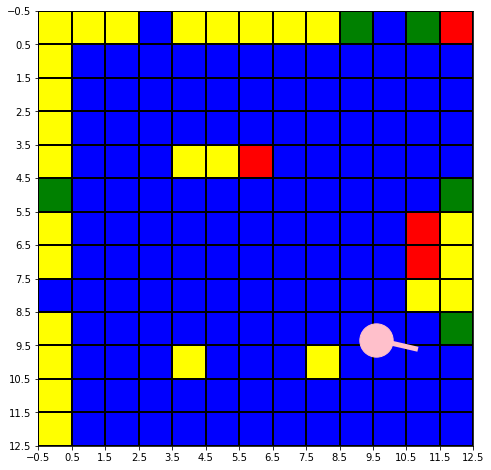

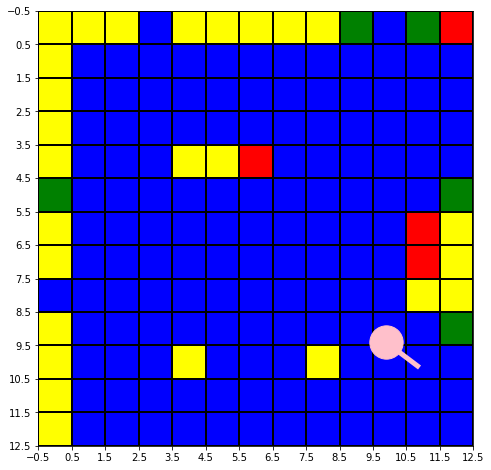

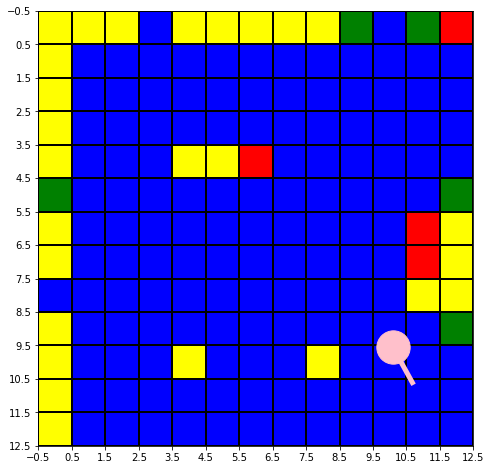

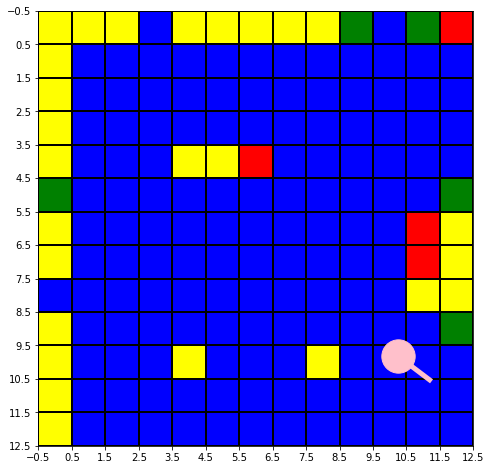

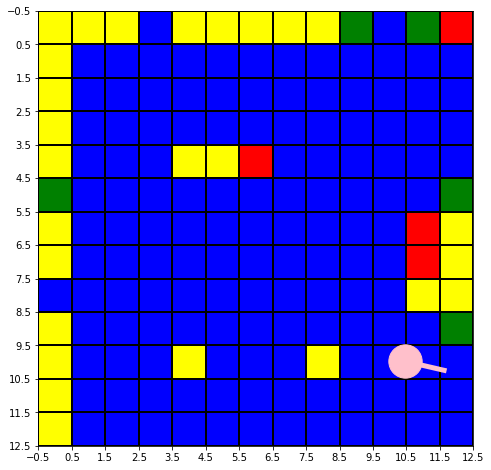

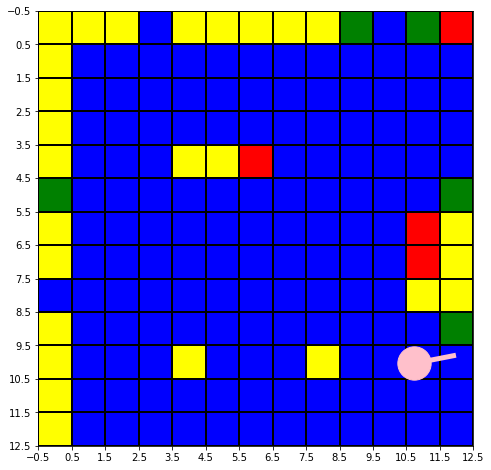

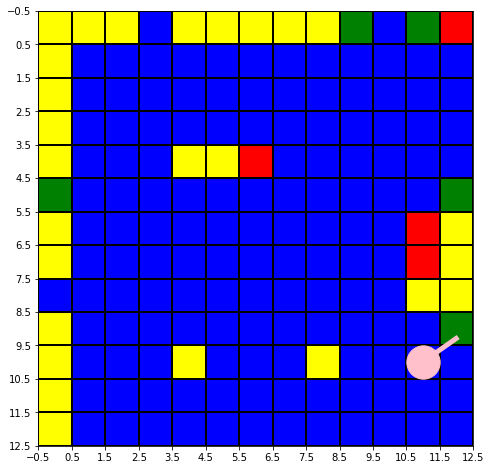

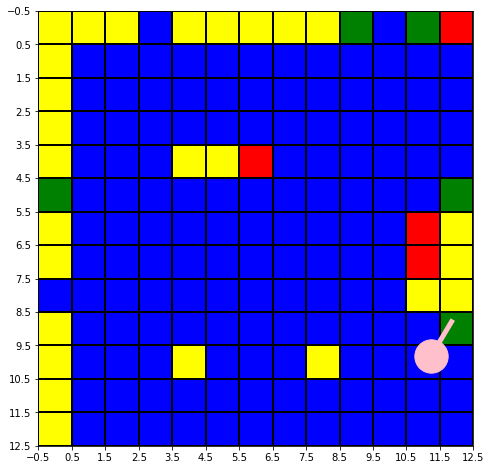

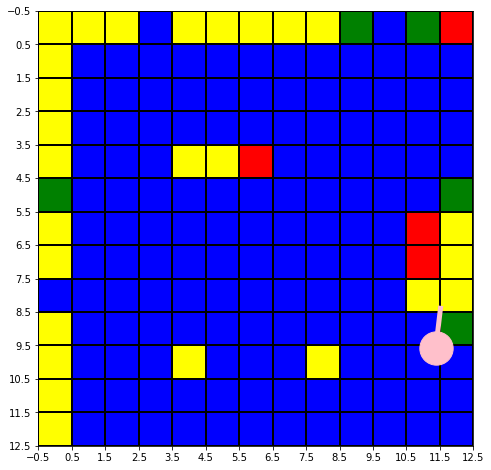

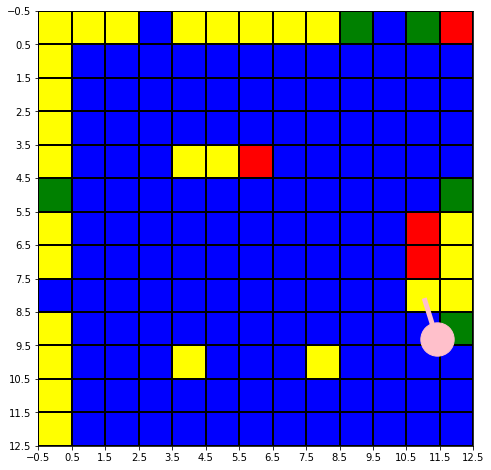

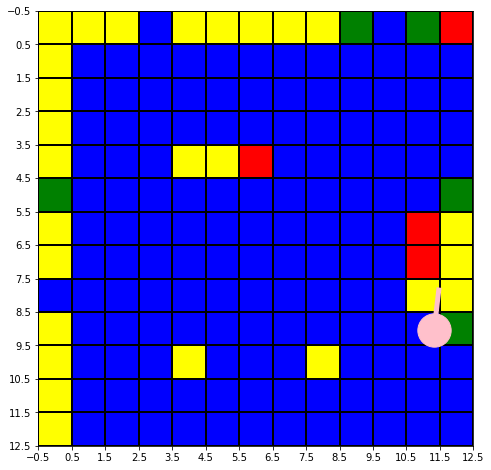

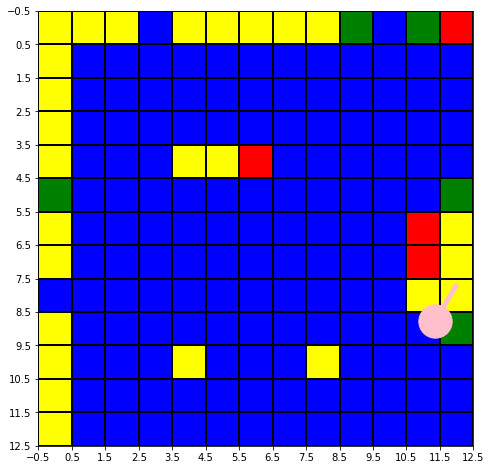

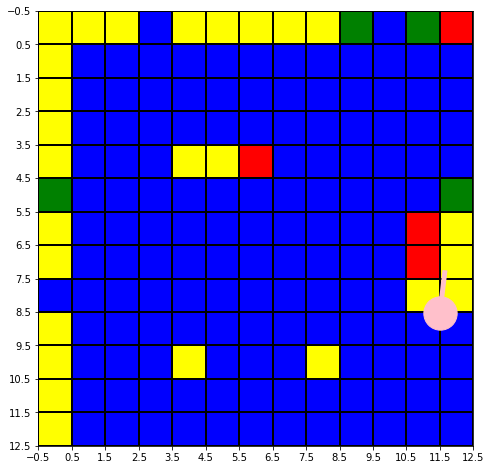

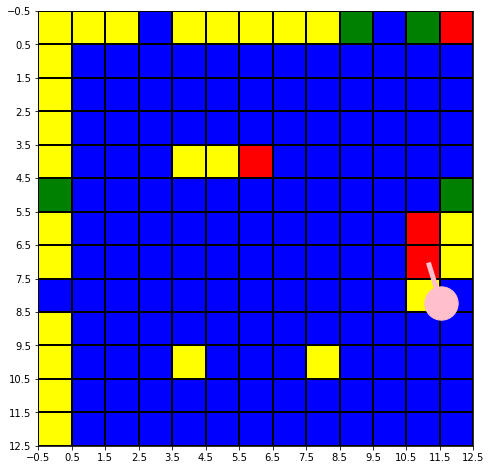

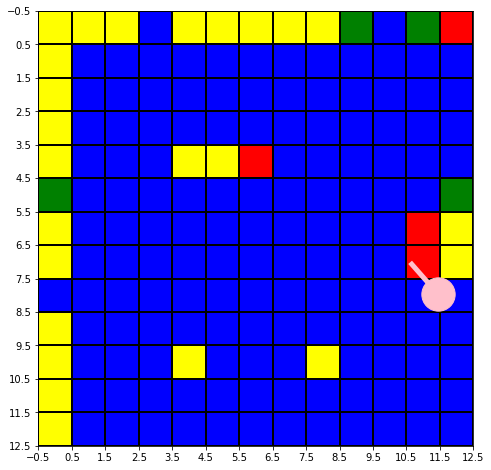

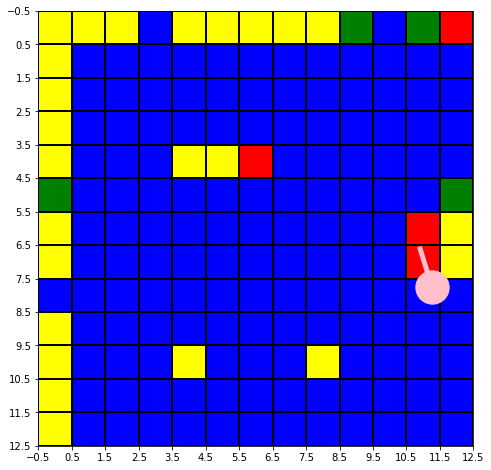

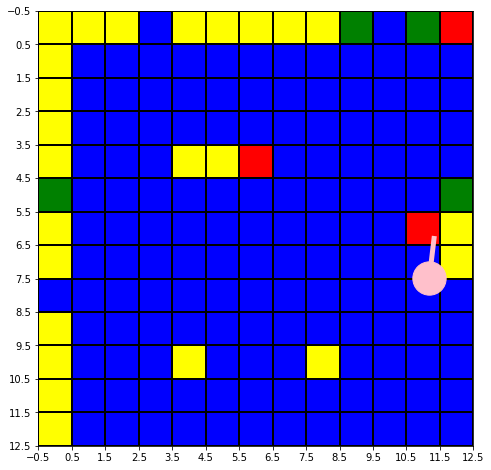

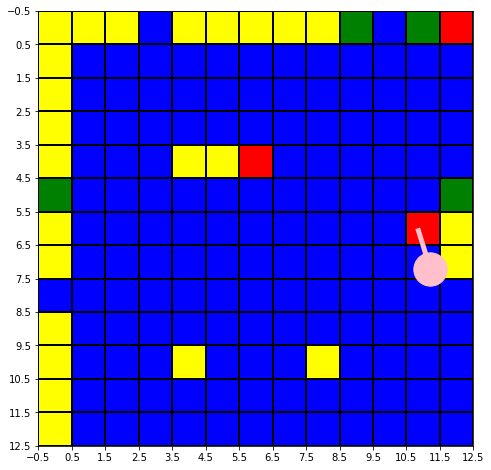

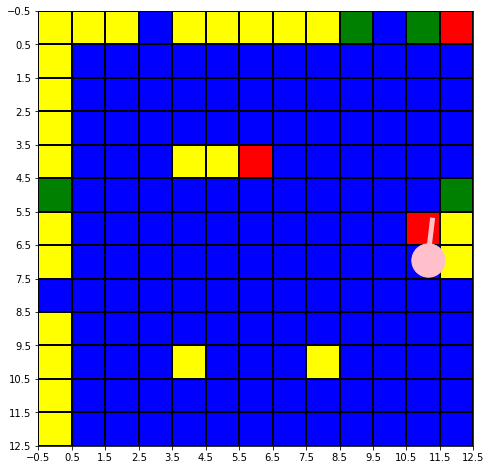

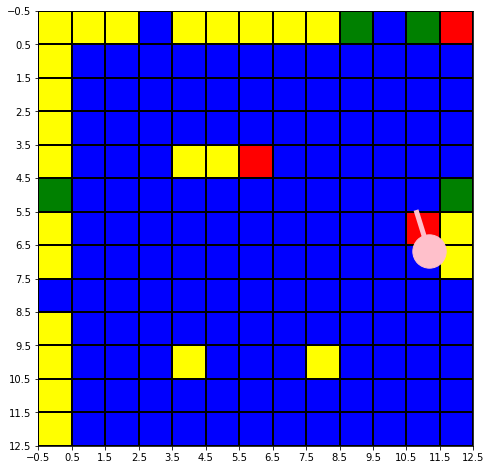

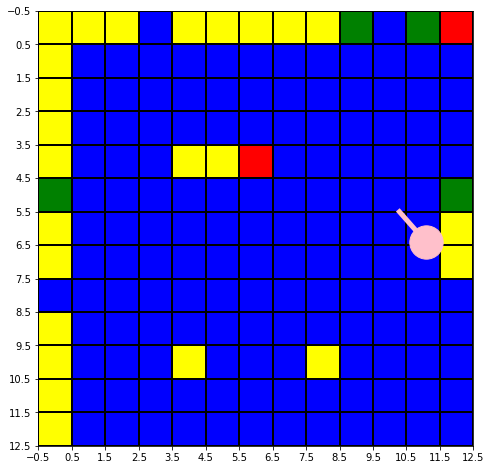

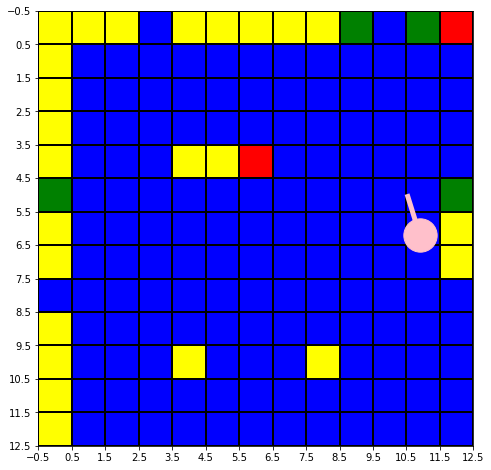

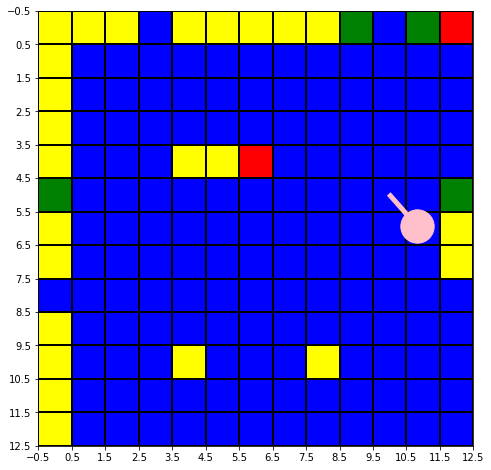

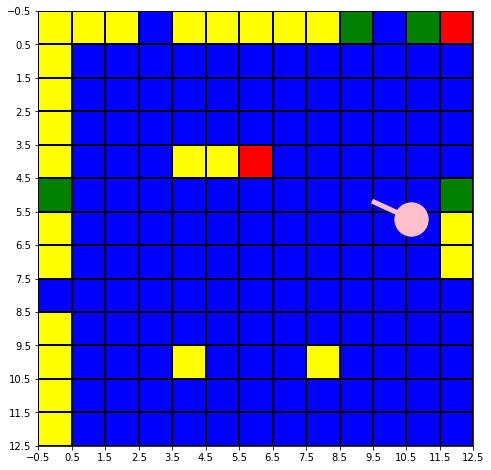

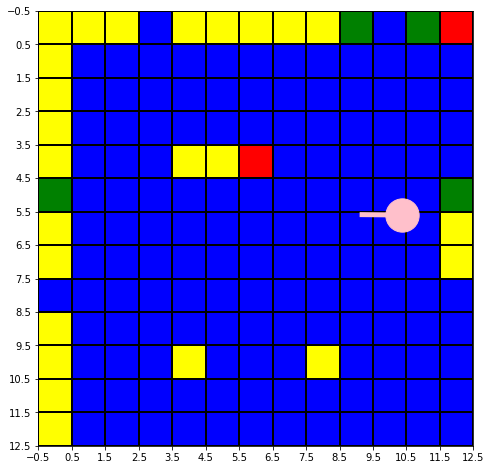

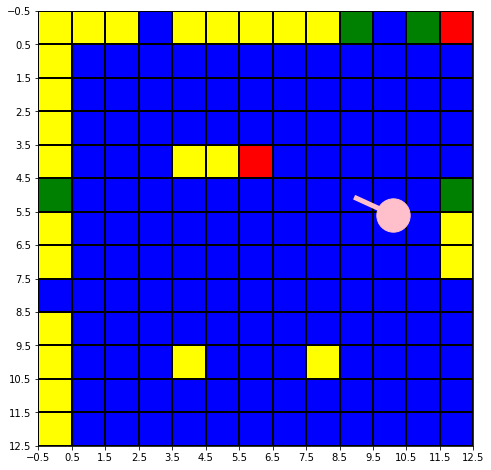

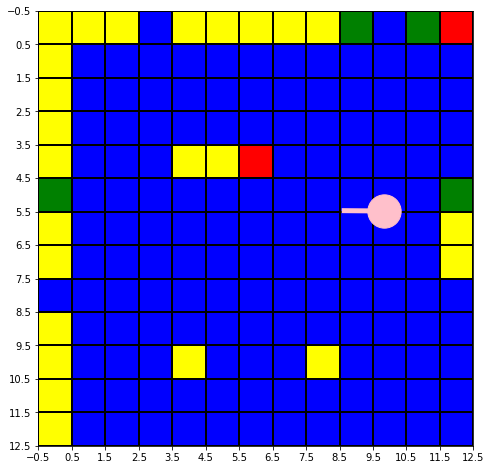

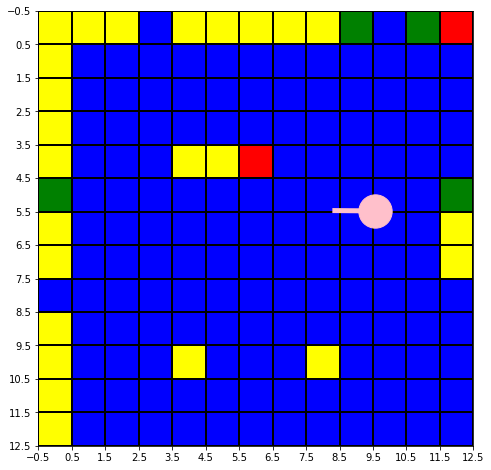

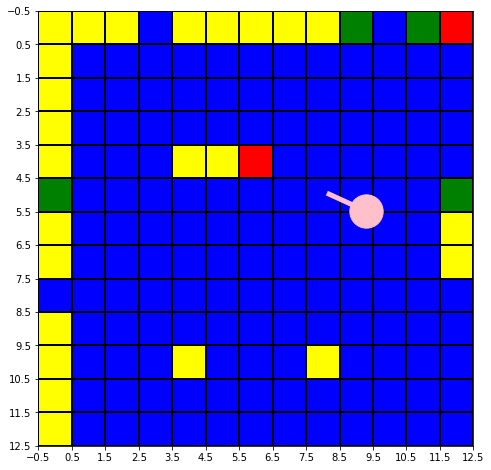

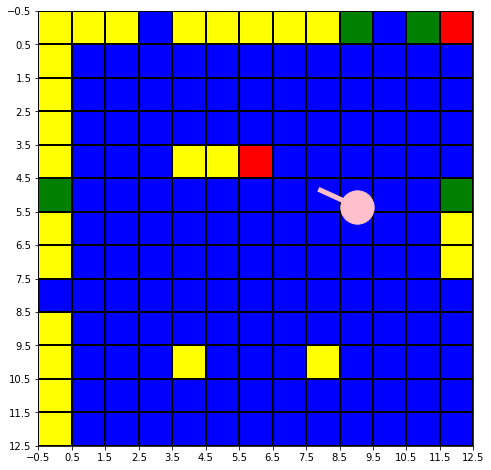

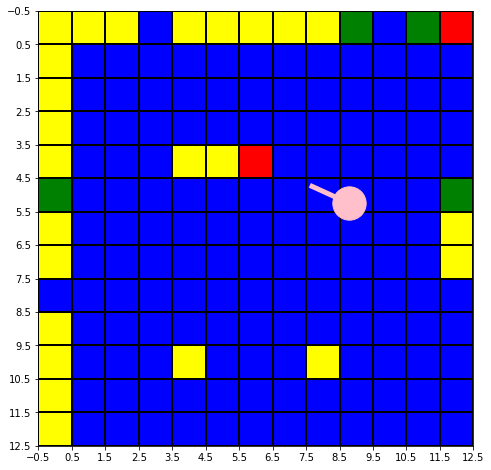

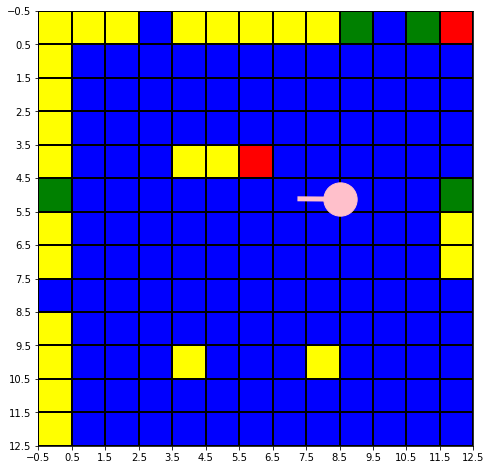

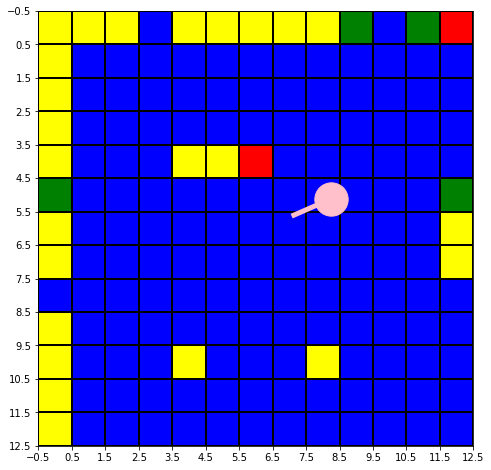

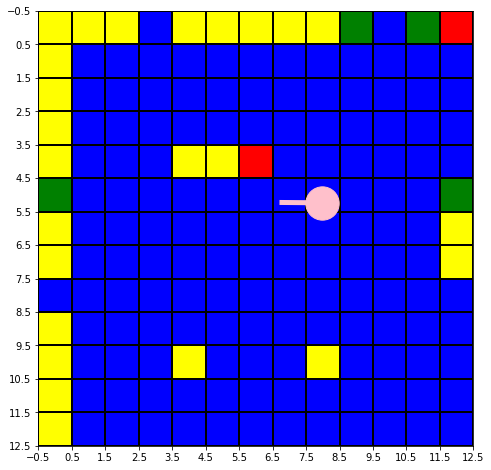

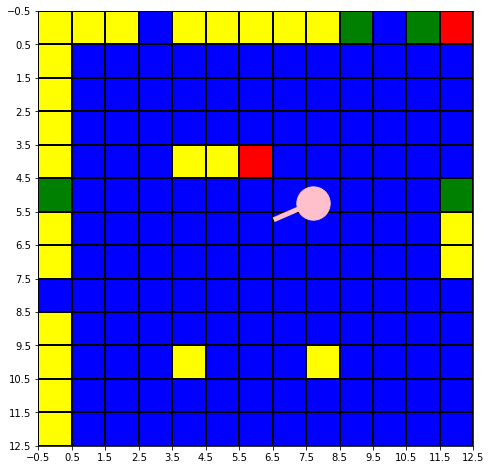

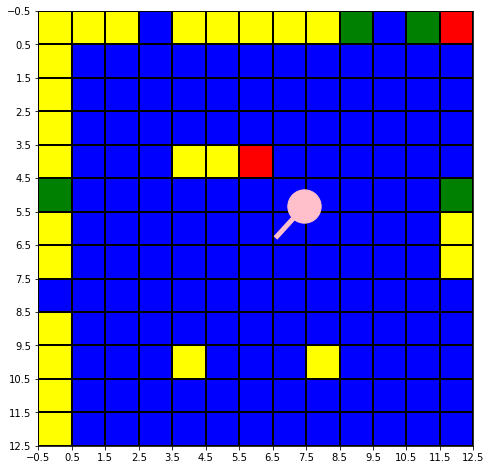

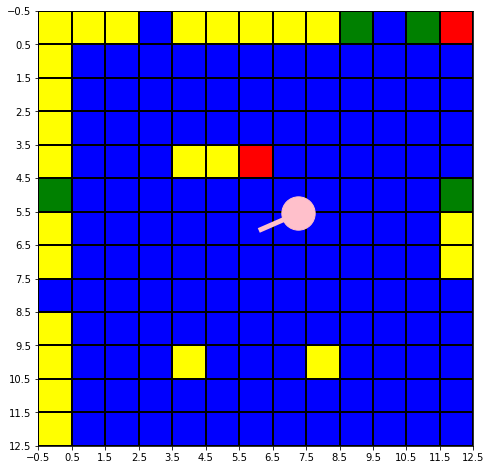

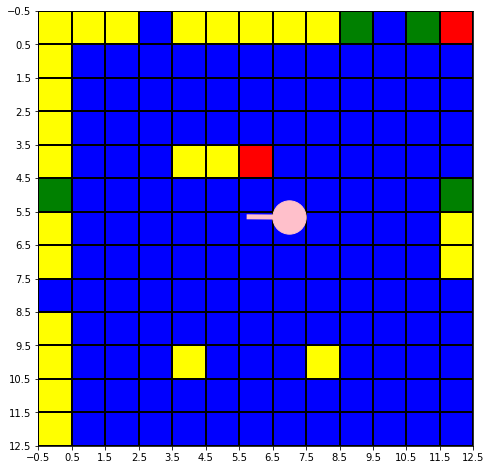

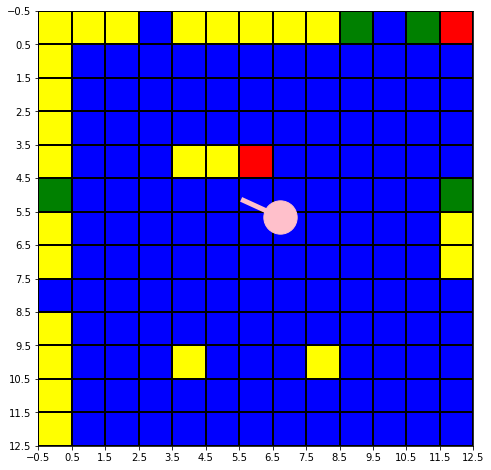

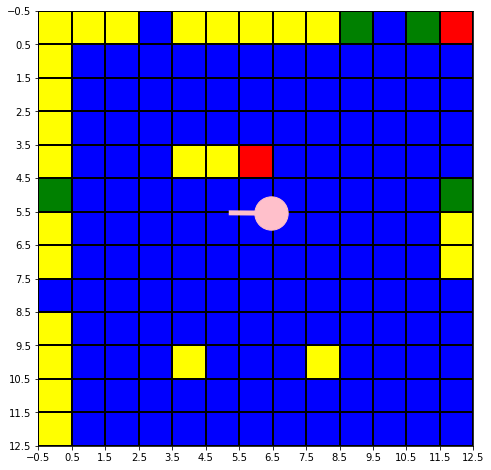

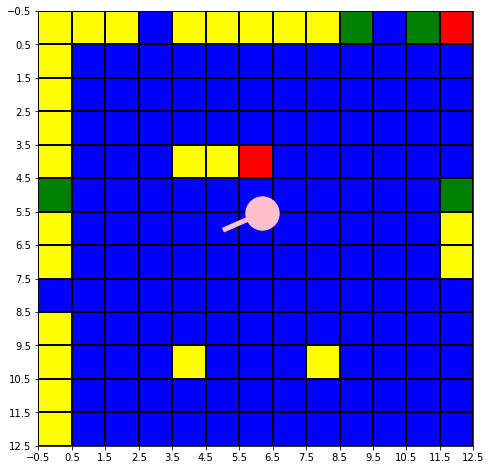

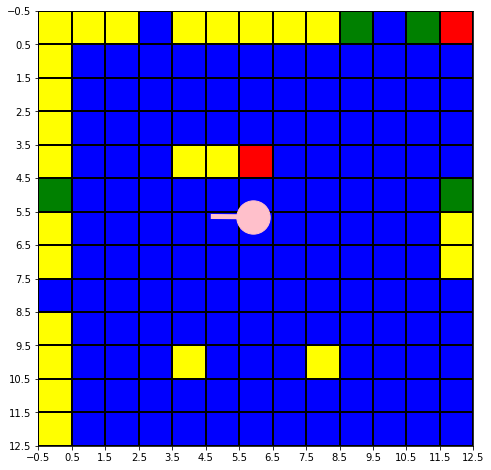

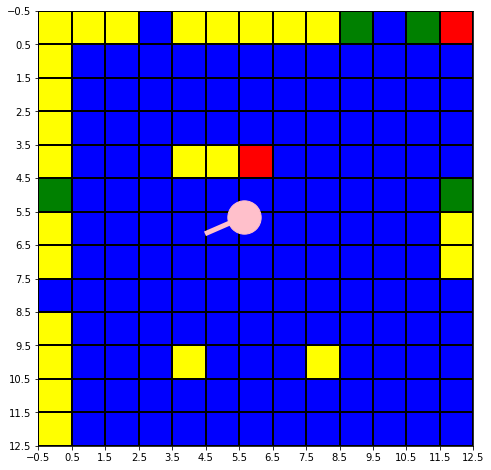

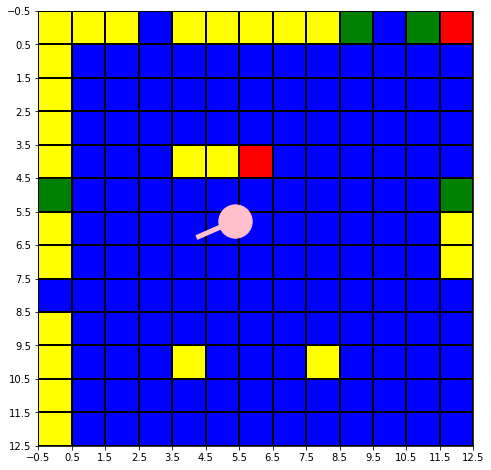

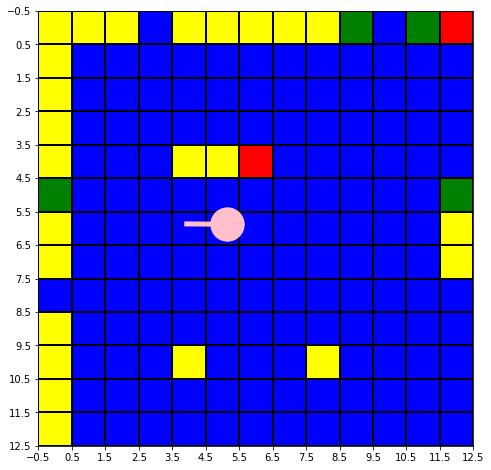

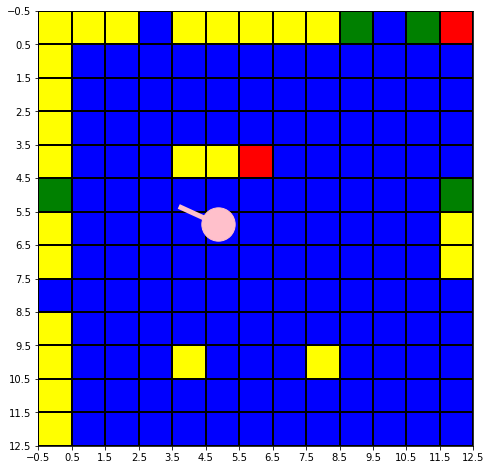

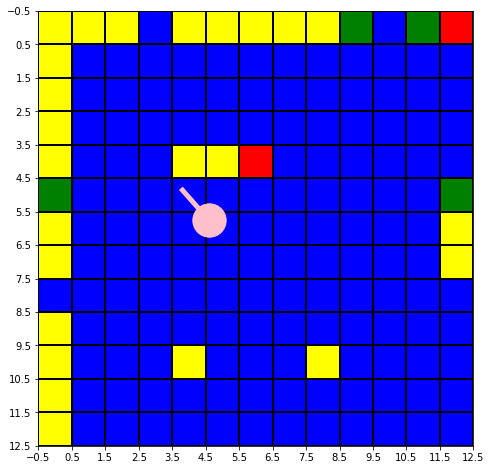

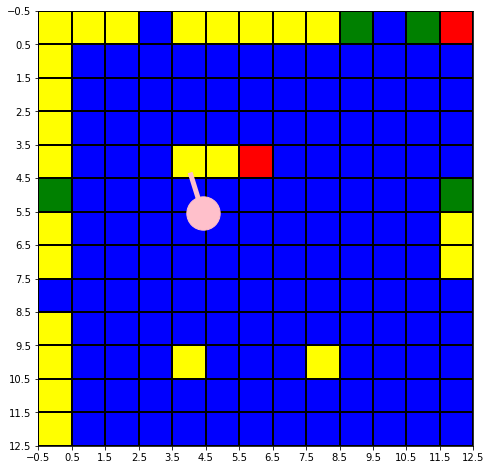

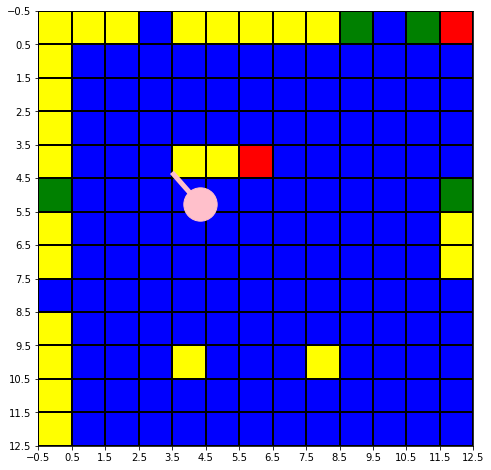

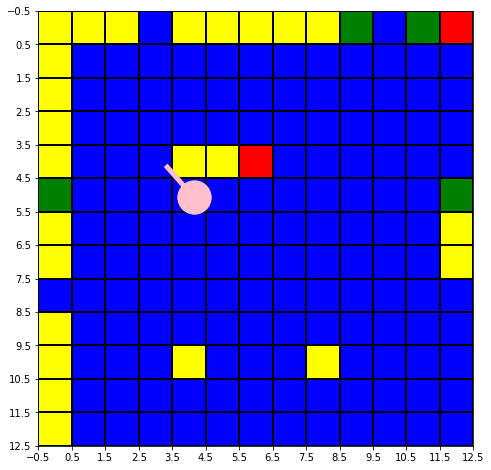

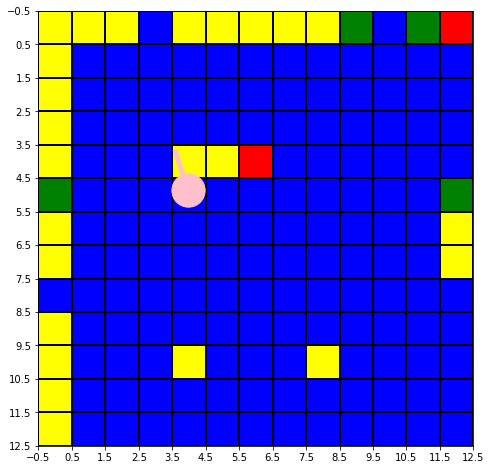

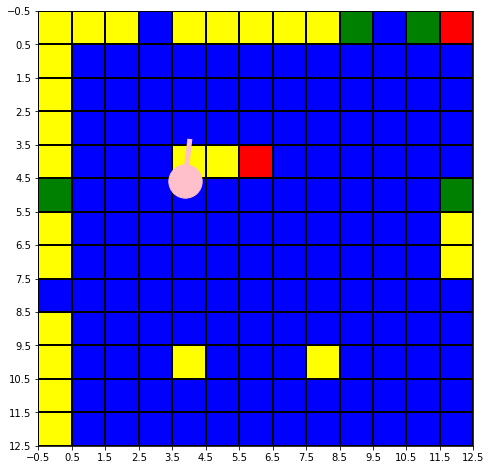

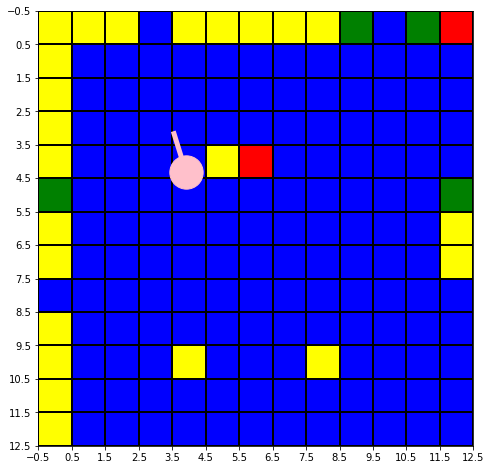

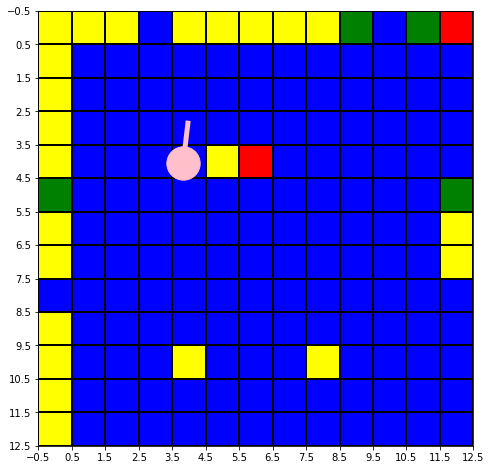

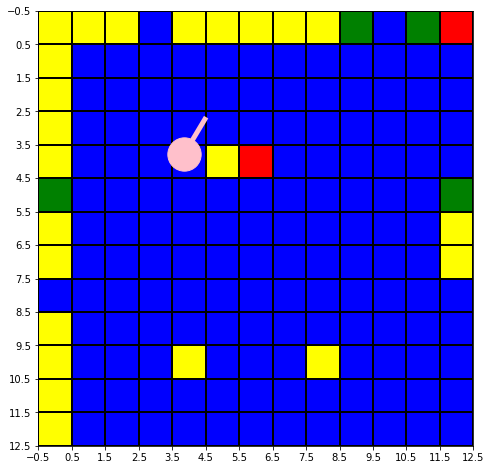

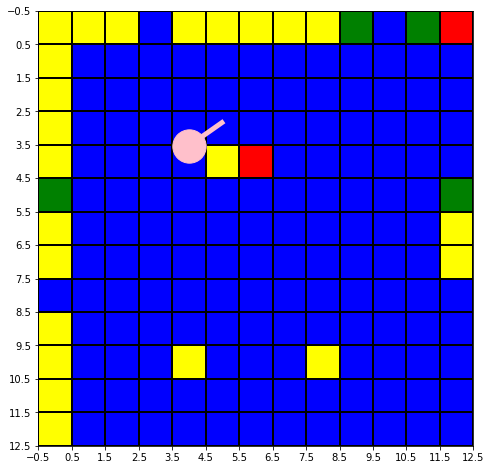

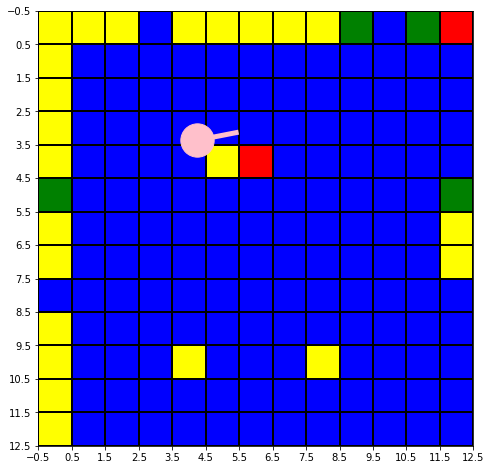

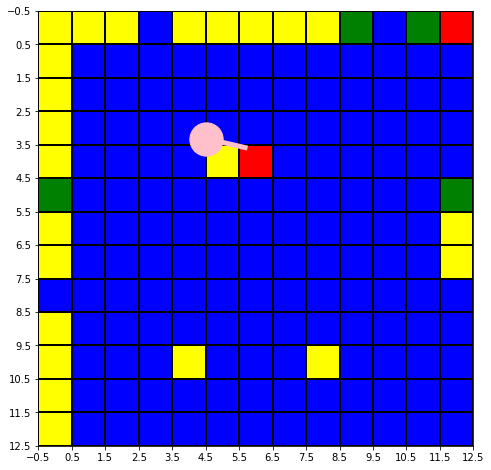

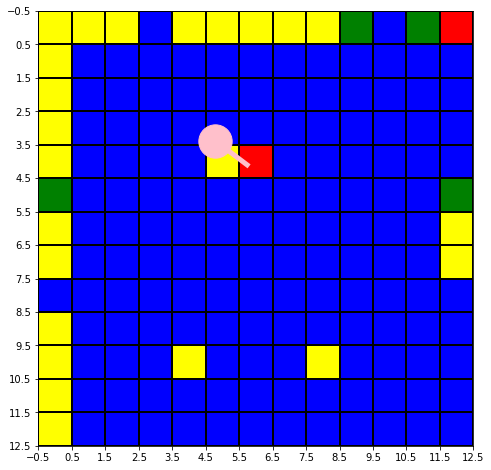

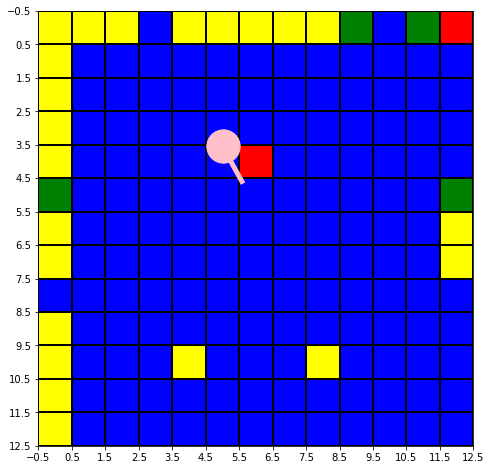

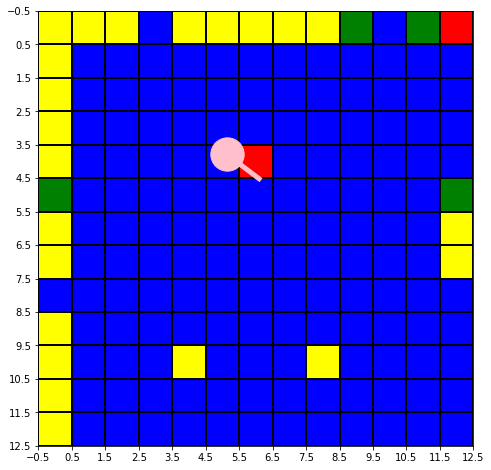

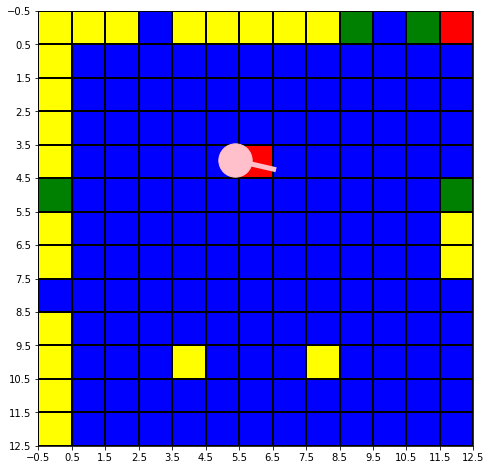

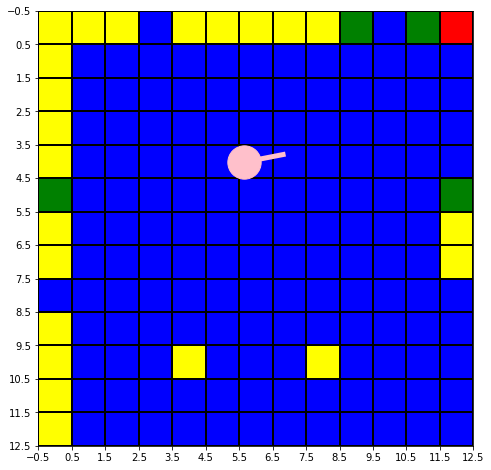

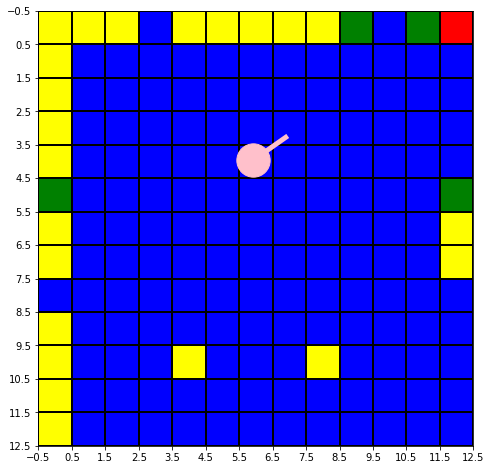

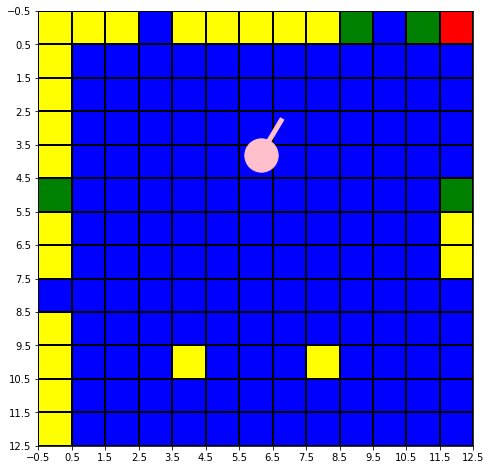

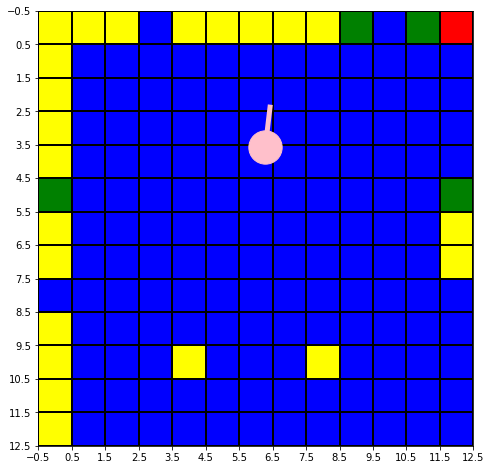

In [81]:
episodes = 1
for episode in range(1, episodes+1):
    obs = env.reset()
    print('------------')
    done = False
    score = 0 
    for i in range(120):
        if done==True:
            break
        action, _states = model.predict(obs)
        obs, reward, dones, info = env.step(action)
        
        score+=reward
        plottagrid(env.reward_grid.reshape(size+1,size+1))
        #time.sleep(0.4)
        #print('mossa numero',env.mossa,'AREA COPERTA',env.state[3],'stato batteria',env.state[4])
        #print('posizione',np.round(env.state[0:3],2),'reward',reward,'azione',action_list[action])
 

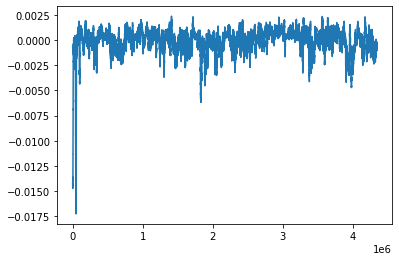

In [ ]:
#NON CANCELLAREEEEEEEEE E IL RISULTATO DELLA MAPPA RANDOMICA, NON FUNZIONA
fig, ax = plt.subplots()
ax.plot(moving_average(reward_listone,10000))

### Prepare video recording

In [ ]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

We will record a video using the [VecVideoRecorder](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html#vecvideorecorder) wrapper, you will learn about those wrapper in the next notebook.

In [ ]:
from stable_baselines.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make('CartPole-v1')])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

### Visualize trained agent



In [ ]:
record_video('CartPole-v1', model, video_length=500, prefix='ppo2-cartpole')

Saving video to  /content/videos/ppo2-cartpole-step-0-to-step-500.mp4


In [ ]:
show_videos('videos', prefix='ppo2')

## Bonus: Train a RL Model in One Line

The policy class to use will be inferred and the environment will be automatically created. This works because both are [registered](https://stable-baselines.readthedocs.io/en/master/guide/quickstart.html).

In [ ]:
model = PPO2('MlpPolicy', "CartPole-v1", verbose=1).learn(1000)

## Train a DQN agent

In the previous example, we have used PPO, which one of the many algorithms provided by stable-baselines.

In the next example, we are going train a [Deep Q-Network agent (DQN)](https://stable-baselines.readthedocs.io/en/master/modules/dqn.html), and try to see possible improvements provided by its extensions (Double-DQN, Dueling-DQN, Prioritized Experience Replay).

The essential point of this section is to show you how simple it is to tweak hyperparameters.

The main advantage of stable-baselines is that it provides a common interface to use the algorithms, so the code will be quite similar.


DQN paper: https://arxiv.org/abs/1312.5602

Dueling DQN: https://arxiv.org/abs/1511.06581

Double-Q Learning: https://arxiv.org/abs/1509.06461

Prioritized Experience Replay: https://arxiv.org/abs/1511.05952

### Vanilla DQN: DQN without extensions

In [ ]:
# Same as before we instantiate the agent along with the environment
from stable_baselines import DQN

# Deactivate all the DQN extensions to have the original version
# In practice, it is recommend to have them activated
kwargs = {'double_q': False, 'prioritized_replay': False, 'policy_kwargs': dict(dueling=False)}

# Note that the MlpPolicy of DQN is different from the one of PPO
# but stable-baselines handles that automatically if you pass a string
dqn_model = DQN('MlpPolicy', env , verbose=1, **kwargs)







Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where









In [ ]:
# Random Agent, before training
mean_reward_before_train = evaluate(dqn_model, num_episodes=100)

mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
mossa 200, MOR


--------------------------------------
| % time spent exploring  | 98       |
| episodes                | 10       |
| mean 100 episode reward | -0.7     |
| steps                   | 160      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 96       |
| episodes                | 20       |
| mean 100 episode reward | -0.8     |
| steps                   | 357      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 94       |
| episodes                | 30       |
| mean 100 episode reward | -0.8     |
| steps                   | 525      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 92       |
| episodes                | 40       |
| mean 100 episode reward | -0.8     |
| steps                   | 774      |
--------------------------------------
--------------------------------------
| % time spent exploring

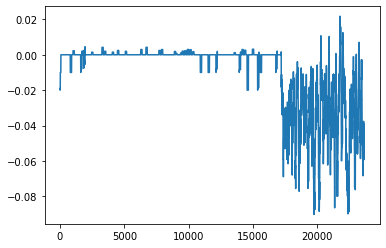

--------------------------------------
| % time spent exploring  | 36       |
| episodes                | 310      |
| mean 100 episode reward | -0.8     |
| steps                   | 6482     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 33       |
| episodes                | 320      |
| mean 100 episode reward | -0.8     |
| steps                   | 6828     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 30       |
| episodes                | 330      |
| mean 100 episode reward | -0.8     |
| steps                   | 7045     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 28       |
| episodes                | 340      |
| mean 100 episode reward | -0.8     |
| steps                   | 7257     |
--------------------------------------
--------------------------------------
| % time spent exploring 

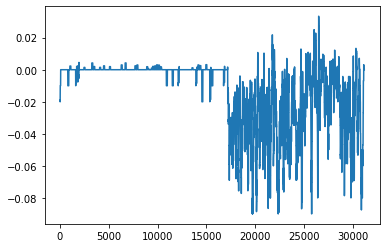

mossa 200, MORTE
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 550      |
| mean 100 episode reward | -0.8     |
| steps                   | 14193    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 560      |
| mean 100 episode reward | -0.8     |
| steps                   | 14624    |
--------------------------------------
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 570      |
| mean 100 episode reward | -0.7     |
| steps                   | 14971    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 580      |
| mean 100 episode reward | -0.7     |
| steps                   | 15423    |
--------------------------------------
Obietti

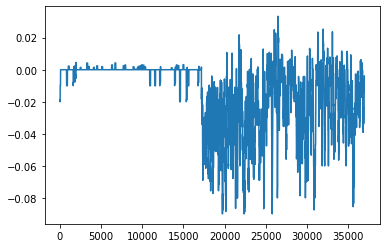

mossa 200, MORTE
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 700      |
| mean 100 episode reward | -0.7     |
| steps                   | 19926    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 710      |
| mean 100 episode reward | -0.7     |
| steps                   | 20310    |
--------------------------------------
Obiettivo raggiunto
Obiettivo raggiunto
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 720      |
| mean 100 episode reward | -0.6     |
| steps                   | 20915    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 730      |
| mean 100 episode reward | -0.7     |
| steps                   | 21131    |
--------------------------

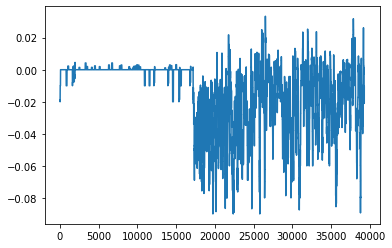

--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 770      |
| mean 100 episode reward | -0.6     |
| steps                   | 22566    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 780      |
| mean 100 episode reward | -0.6     |
| steps                   | 22965    |
--------------------------------------
mossa 200, MORTE
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 790      |
| mean 100 episode reward | -0.6     |
| steps                   | 23340    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 800      |
| mean 100 episode reward | -0.6     |
| steps                   | 23538    |
--------------------------------------
Obiettivo raggiunto
---------------------------

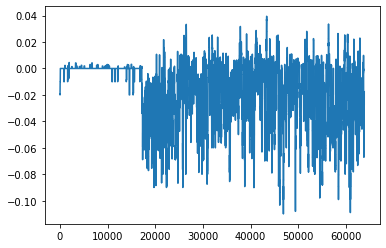

Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 1540     |
| mean 100 episode reward | -0.7     |
| steps                   | 46905    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 1550     |
| mean 100 episode reward | -0.7     |
| steps                   | 47213    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 1560     |
| mean 100 episode reward | -0.7     |
| steps                   | 47460    |
--------------------------------------
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 1570     |
| mean 100 episode reward | -0.7     |
| steps                   | 47713    |
--------------------------------------
mossa 200, MORTE
Obietti

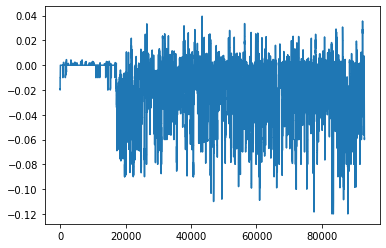

Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 2520     |
| mean 100 episode reward | -0.7     |
| steps                   | 75934    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 2530     |
| mean 100 episode reward | -0.7     |
| steps                   | 76349    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 2540     |
| mean 100 episode reward | -0.7     |
| steps                   | 76465    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 2550     |
| mean 100 episode reward | -0.8     |
| steps                   | 76637    |
--------------------------------------
--------------------------------------
| % t

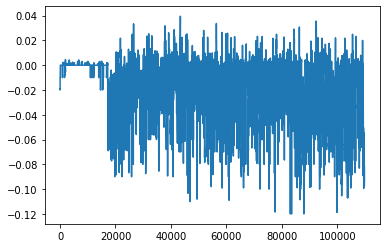

Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 3190     |
| mean 100 episode reward | -0.8     |
| steps                   | 92703    |
--------------------------------------
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 3200     |
| mean 100 episode reward | -0.8     |
| steps                   | 93110    |
--------------------------------------
mossa 200, MORTE
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 3210     |
| mean 100 episode reward | -0.8     |
| steps                   | 93466    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 3220     |
| mean 100 episode reward | -0.8     |
| steps                   | 93610    |
--------------------------------------
Obietti

In [ ]:
# Train the agent for 10000 steps
dqn_model.learn(total_timesteps=100000, log_interval=10)

In [ ]:
# Evaluate the trained agent
mean_reward = evaluate(dqn_model, num_episodes=100)

Mean reward: 130.02 Num episodes: 100


### DQN + Prioritized Replay

In [ ]:
# Activate only the prioritized replay
kwargs = {'double_q': False, 'prioritized_replay': True, 'policy_kwargs': dict(dueling=False)}

dqn_per_model = DQN('MlpPolicy', 'CartPole-v1', verbose=1, **kwargs)

In [ ]:
dqn_per_model.learn(total_timesteps=10000, log_interval=10)

In [ ]:
# Evaluate the trained agent
mean_reward = evaluate(dqn_per_model, num_episodes=100)

Mean reward: 110.18 Num episodes: 100


### DQN + Prioritized Experience Replay + Double Q-Learning + Dueling

In [ ]:
# Activate all extensions
kwargs = {'double_q': True, 'prioritized_replay': True, 'policy_kwargs': dict(dueling=True)}

dqn_full_model = DQN('MlpPolicy', env, verbose=1, **kwargs)


Obiettivo raggiunto


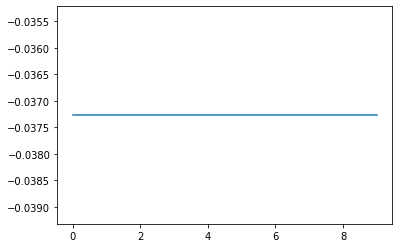

--------------------------------------
| % time spent exploring  | 90       |
| episodes                | 100      |
| mean 100 episode reward | -0.8     |
| steps                   | 1859     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 82       |
| episodes                | 200      |
| mean 100 episode reward | -0.8     |
| steps                   | 3636     |
--------------------------------------


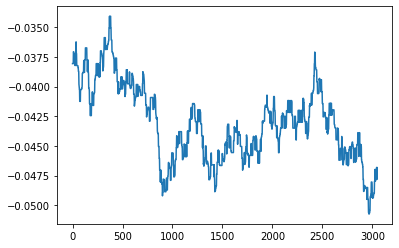

Obiettivo raggiunto
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 73       |
| episodes                | 300      |
| mean 100 episode reward | -0.7     |
| steps                   | 5425     |
--------------------------------------


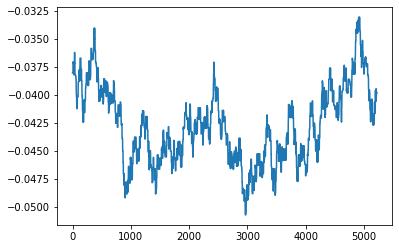

Obiettivo raggiunto


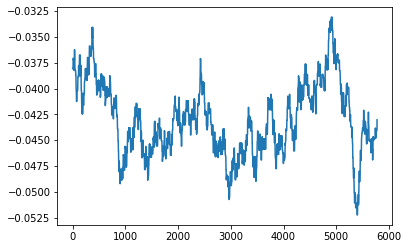

--------------------------------------
| % time spent exploring  | 64       |
| episodes                | 400      |
| mean 100 episode reward | -0.8     |
| steps                   | 7193     |
--------------------------------------
Obiettivo raggiunto
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 56       |
| episodes                | 500      |
| mean 100 episode reward | -0.8     |
| steps                   | 8978     |
--------------------------------------
Obiettivo raggiunto
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 45       |
| episodes                | 600      |
| mean 100 episode reward | -0.7     |
| steps                   | 11130    |
--------------------------------------
Obiettivo raggiunto
Obiettivo raggiunto
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 34       |
| episodes                | 700      |
| mean 100 episode reward | -0.7     |
| 

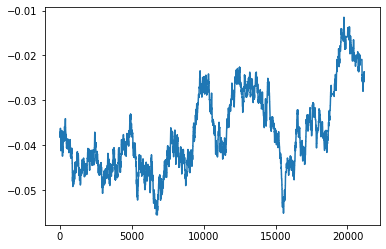

mossa 200, MORTE
mossa 200, MORTE
mossa 200, MORTE
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 1100     |
| mean 100 episode reward | -0.6     |
| steps                   | 23282    |
--------------------------------------
Obiettivo raggiunto
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 1200     |
| mean 100 episode reward | -0.8     |
| steps                   | 25349    |
--------------------------------------
Obiettivo raggiunto
Obiettivo raggiunto
Obiettivo raggiunto
mossa 200, MORTE
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 1300     |
| mean 100 episode reward | -0.8     |
| steps                   | 27615    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 1400     |
| mean 100 ep

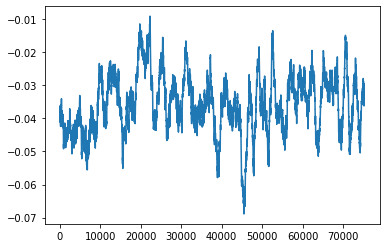

--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 3500     |
| mean 100 episode reward | -0.8     |
| steps                   | 76868    |
--------------------------------------
mossa 200, MORTE
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 3600     |
| mean 100 episode reward | -0.8     |
| steps                   | 78960    |
--------------------------------------
mossa 200, MORTE
mossa 200, MORTE
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 3700     |
| mean 100 episode reward | -0.7     |
| steps                   | 81360    |
--------------------------------------
mossa 200, MORTE
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 3800     |
| mean 100 episode reward | -0.8     |
| steps                   | 83560    |
---------------

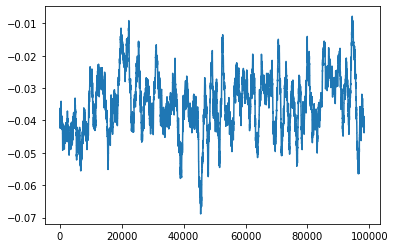

--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 4500     |
| mean 100 episode reward | -0.8     |
| steps                   | 100210   |
--------------------------------------
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 4600     |
| mean 100 episode reward | -0.8     |
| steps                   | 102836   |
--------------------------------------
Obiettivo raggiunto
Obiettivo raggiunto
mossa 200, MORTE
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 4700     |
| mean 100 episode reward | -0.8     |
| steps                   | 105176   |
--------------------------------------
Obiettivo raggiunto
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 4800     |
| mean 100 episode reward | -0.7     |
| steps                  

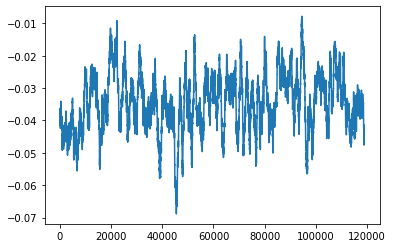

--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 5400     |
| mean 100 episode reward | -0.8     |
| steps                   | 121255   |
--------------------------------------
Obiettivo raggiunto
Obiettivo raggiunto
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 5500     |
| mean 100 episode reward | -0.7     |
| steps                   | 123588   |
--------------------------------------
Obiettivo raggiunto


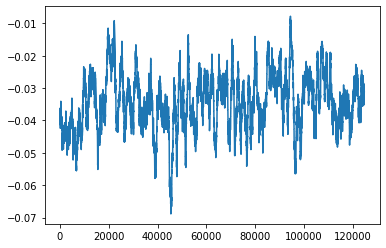

--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 5600     |
| mean 100 episode reward | -0.7     |
| steps                   | 126022   |
--------------------------------------
Obiettivo raggiunto
Obiettivo raggiunto
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 5700     |
| mean 100 episode reward | -0.7     |
| steps                   | 128349   |
--------------------------------------
Obiettivo raggiunto
mossa 200, MORTE
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 5800     |
| mean 100 episode reward | -0.7     |
| steps                   | 130719   |
--------------------------------------
Obiettivo raggiunto
Obiettivo raggiunto
mossa 200, MORTE
Obiettivo raggiunto


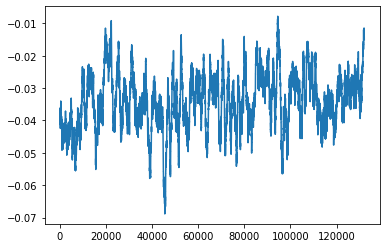

Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 5900     |
| mean 100 episode reward | -0.6     |
| steps                   | 133729   |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 6000     |
| mean 100 episode reward | -0.8     |
| steps                   | 135951   |
--------------------------------------
Obiettivo raggiunto
Obiettivo raggiunto
mossa 200, MORTE
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 6100     |
| mean 100 episode reward | -0.7     |
| steps                   | 138176   |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 6200     |
| mean 100 episode reward | -0.8     |
| steps                   | 140447   |
------

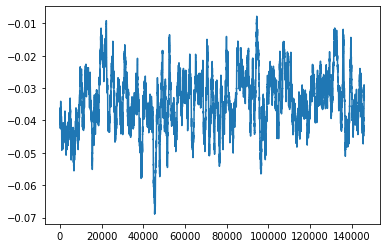

--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 6600     |
| mean 100 episode reward | -0.8     |
| steps                   | 149414   |
--------------------------------------
Obiettivo raggiunto


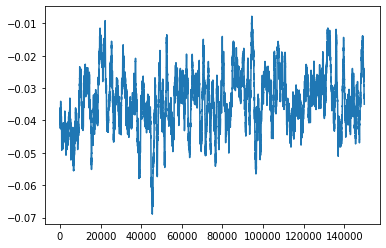

--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 6700     |
| mean 100 episode reward | -0.8     |
| steps                   | 151566   |
--------------------------------------
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 6800     |
| mean 100 episode reward | -0.8     |
| steps                   | 153759   |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 6900     |
| mean 100 episode reward | -0.9     |
| steps                   | 155661   |
--------------------------------------
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 7000     |
| mean 100 episode reward | -0.8     |
| steps                   | 157582   |
--------------------------------------
Obiettivo raggiunto
Obie

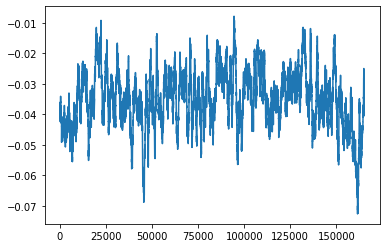

--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 7500     |
| mean 100 episode reward | -0.9     |
| steps                   | 166293   |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 7600     |
| mean 100 episode reward | -0.9     |
| steps                   | 168003   |
--------------------------------------
Obiettivo raggiunto
mossa 200, MORTE
Obiettivo raggiunto
Obiettivo raggiunto
Obiettivo raggiunto
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 7700     |
| mean 100 episode reward | -0.7     |
| steps                   | 170335   |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 7800     |
| mean 100 episode reward | -0.9     |
| steps                   | 171923   |
------

In [ ]:
dqn_full_model.learn(total_timesteps=200000, log_interval=100)

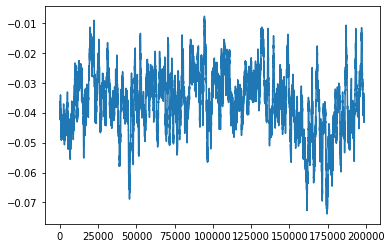

In [ ]:
fig, ax = plt.subplots()
ax.plot(moving_average(reward_listone,1000))
plt.show()

In [ ]:
mean_reward = evaluate(dqn_per_model, num_episodes=100)

Mean reward: 110.02 Num episodes: 100


In this particular example, the extensions does not seem to give any improvement compared to the simple DQN version.
They are several reasons for that:

1. `CartPole-v1` is a pretty simple environment
2. We trained DQN for very few timesteps, not enough to see any difference
3. The default hyperparameters for DQN are tuned for atari games, where the number of training timesteps is much larger (10^6) and input observations are images
4. We have only compared one random seed per experiment

## Conclusion

In this notebook we have seen:
- how to define and train a RL model using stable baselines, it takes only one line of code ;)
- how to use different RL algorithms and change some hyperparameters